# Theory Approximations
This runs through derivation of theory, to gain two exact equations for $\delta \Delta h^{\dagger}$, one from free troposphere and surface. In the derivation, I quantify approximations I make using different $A$ values.

It also allows you to specify the reference day that the theory is built around, indicated by the tilde.

In [1]:
import copy
import sys
import os
# REMOTE - So can access functions in isca_tools which is in home/Isca directory
# sys.path.append(os.path.join(os.environ['HOME'], 'Isca'))
# LOCAL - So can access functions in isca_tools which is in StAndrews/Isca
sys.path.append(os.environ['PWD'])
import isca_tools
from isca_tools.utils.moist_physics import moist_static_energy, clausius_clapeyron_factor, sphum_sat
from isca_tools.utils.constants import kappa, L_v, c_p, g, R
from isca_tools.utils import area_weighting
from isca_tools.papers.byrne_2021 import get_quant_ind
from isca_tools.thesis.adiabat_theory import get_theory_prefactor_terms, get_temp_adiabat
from isca_tools.thesis.adiabat_theory2 import get_approx_terms, get_scale_factor_theory
from isca_tools.plot import label_subplots
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import scipy.optimize
from tqdm.notebook import tqdm
from scipy import integrate
import numpy_indexed
from scipy.stats import percentileofscore
import copy
# Use custom matplotlib style for publishing
plt.style.use('/Users/joshduffield/Documents/StAndrews/Isca/jobs/tau_sweep/aquaplanet/publish_figures/publish.mplstyle')

In [618]:
# Load dataset - one at surface and one in free troposphere
var_keep = ['temp', 'sphum', 'height']        # only keep variables required to compute relative humidity and MSE


use_time_start = 360*2
pressure_ft = 500               # Desired approximate pressure of free troposphere (hPa)

# Load dataset
tau_lw_ref = 1
tau_lw_warm = 1.5
# refer to bucket model with vegetation as bucket
# Don't include actual bucket, as looks very similar to bucket with vegetation param
# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
exp_dir = 'tau_sweep/land/meridional_band/depth=1/bucket_evap/'
# exp_dir = 'tau_sweep/aquaplanet/depth=1/'

# exp_names = ['Aquaplanet', 'Constant conductivity', 'Bucket', 'Bucket - $C_V$']
# exp_dir = ['tau_sweep/aquaplanet/', 'tau_sweep/land/meridional_band/evap/', 'tau_sweep/land/meridional_band/bucket/',
#            'tau_sweep/land/meridional_band/bucket_evap/evap=0_1/']
# color_seq_exp = ['b', 'g', 'orange', 'r']

kappa_names = [f"k={str(tau_lw_ref).replace('.','_')}", f"k={str(tau_lw_warm).replace('.','_')}"]
n_kappa = len(kappa_names)
ds = []
albedo = []
tau_sw = []
tau_lw = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = isca_tools.load_dataset(exp_dir + kappa_names[j]).sel(time=slice(use_time_start, np.inf))[var_keep]
        
        ds += [ds_use.sel(pfull=[np.inf, pressure_ft], method='nearest')]      # only keep the surface and free troposphere values
        namelist = isca_tools.load_namelist(exp_dir + kappa_names[j])  # Need this for albedo_value
        albedo += [namelist['mixed_layer_nml']['albedo_value']]
        tau_sw += [namelist['two_stream_gray_rad_nml']['atm_abs']]
        tau_lw += [namelist['two_stream_gray_rad_nml']['odp']]
        pbar.update(1)
        
pfull = ds_use.pfull
ind_surf = 0
ind_ft = 1
p_surface = float(ds[0].pfull[ind_surf]) * 100
pressure_ft_actual = float(ds[0].pfull[ind_ft]) * 100       # Actual pressure of free troposphere (Pa)
n_pressure = ds[0].pfull.size
lnp_const = R * np.log(p_surface/pressure_ft_actual)/2      # for modified MSE calculation

  0%|          | 0/2 [00:00<?, ?it/s]

## Get datasets
Get one dataset for summer for each $\kappa$, combining all latitudes: `ds_all`. This combines the all or just tbe summer months in each hemisphere, e.g. negative latitudes will only correspond to times in December, January or February.

In [619]:
# If true, will save all figures to desktop - option to save specific figures later on.
save_fig = False
# if publishing figure, use high dpi
publish_fig = True

ar = 4/3        # aspect ratio (width/height)
# Details required for Journal of Climate Figures
low_dpi = 100
dpi = {'monochrome': 1100, 'combination': 800, 'halftone': 300}
width = {'one_col': 3.2, 'two_col': 5.5}        # width in inches 
save_pad_inches = 0.05
im_sz = 1.5


# Default parameters
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_exp = [default_colors[0], default_colors[1]]
ax_linewidth = plt.rcParams['axes.linewidth']


labels_exp = ['$\kappa={:.1f}$'.format(tau_lw[i]) for i in range(n_kappa)]

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

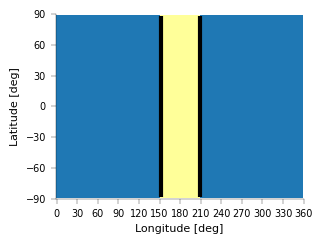

In [620]:
# Show where the land is
save_land_fig = False

job_dir = os.path.join(os.path.dirname(os.environ['GFDL_DATA']), 'jobs')
land_file_name = os.path.join(job_dir, exp_dir, kappa_names[0], 'land.nc')
is_land_data = os.path.exists(land_file_name)
if is_land_data:
    fig, ax = plt.subplots(1,1, figsize=(width['one_col'], width['one_col']/ar))
    isca_tools.plot.show_land(land_file_name, fig=fig, ax=ax)
    lon_land = isca_tools.utils.land.get_land_coords(land_file=land_file_name)[1]       # get the longitude coordinates of land
    
    if save_fig or save_land_fig:
        fig.savefig(f"/Users/joshduffield/Desktop/land_coords.pdf",
                    dpi=dpi['combination'] if publish_fig else low_dpi, bbox_inches='tight', pad_inches=save_pad_inches)

In [727]:
# Load in across all latitudes, for given season

# Select region to combine latitudes over for all but one of the plots below
# Tropics
region = 'tropics'
lat_min = 0
lat_max = 20
# Extratropics
# region = 'extratropics'
# lat_min = 40
# lat_max = 65
# lat_min = 70
# lat_max = 90

# Chose whether to only consider summer days or consider all days
season = 'all'
# season = 'summer'
# season = 'winter'
if season == 'summer':
    if region == 'tropics':
        season_months = {'nh': [5, 6, 7, 8, 9, 10], 'sh': [11, 12, 1, 2, 3, 4]}   
    else:
        season_months = {'nh': [6, 7, 8], 'sh': [12, 1, 2]}   # JJA for NH and DJF for SH
elif season == 'winter':
    if region == 'tropics':
        season_months = {'sh': [5, 6, 7, 8, 9, 10], 'nh': [11, 12, 1, 2, 3, 4]}
    else:
        season_months = {'sh': [6, 7, 8], 'nh': [12, 1, 2]} 

lat_use_ind = np.where((np.abs(ds[0].lat) <= lat_max) & (np.abs(ds[0].lat) >= lat_min))[0]
n_lat = len(lat_use_ind)
lat_weights = np.cos(np.deg2rad(ds[0].lat))[lat_use_ind]
lat = ds[0].lat[lat_use_ind].to_numpy()

# Whether to do taylor expansion about mean over just land or mean over whole planet
mean_method = 'land'
# mean_method = 'all'

temp_av = {key: np.zeros((n_kappa, n_pressure, n_lat)) for key in ['mean', 'median']}
z_av = {key: np.zeros((n_kappa, n_pressure, n_lat)) for key in ['mean', 'median']}
r_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}
epsilon_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}
z_approx_error_av = {key: np.zeros((n_kappa, n_lat)) for key in ['mean', 'median']}        # error in z used in mse_mod approx
# Decide how to compute humidities - do q first and then r from this ('sphum'), or vice versa ('r')?

R_mod = get_theory_prefactor_terms(0, p_surface, pressure_ft_actual)[0]   # need to compute mse_mod

ds_all = []
with tqdm(total=n_kappa, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds[j].isel(lat=lat_use_ind)   # only keep latitudes being used to save memory
        
        if is_land_data:
            # if not aquaplanet, then is land and only consider land longitudes
            ds_use = ds_use.isel(lon=np.where(np.isin(ds_use.lon, np.unique(lon_land)))[0])
        
        if season in ['summer', 'winter']:
            ds_nh_season = isca_tools.utils.annual_time_slice(ds_use, season_months['nh']).sel(lat=slice(0, 90))
            ds_sh_season = isca_tools.utils.annual_time_slice(ds_use, season_months['sh']).sel(lat=slice(-90, 0))
            # Combine hemispheres and average over longitude, time and latitude.
            ds_use = xr.concat([ds_sh_season, ds_nh_season], dim='lat')
        ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        ds_all += [ds_use.load()]
        
        if mean_method == 'all':
            ds_use = ds[j].sel(time=slice(use_time_start, np.inf)).isel(lat=lat_use_ind)
            ds_use = ds_use.stack(lon_time=("lon","time"), create_index=False).chunk(dict(lon_time=-1))
        elif mean_method != 'land':
            raise ValueError(f'Mean method is {mean_method} which is not valid.')
        temp_av['mean'][j] = ds_use.temp.mean(dim='lon_time')
        temp_av['median'][j] = ds_use.temp.median(dim='lon_time')
        z_av['mean'][j] = ds_use.height.mean(dim='lon_time')
        z_av['median'][j] = ds_use.height.mean(dim='lon_time')
        rh_use = ds_use.sphum.isel(pfull=ind_surf)/sphum_sat(ds_use.temp.isel(pfull=ind_surf), p_surface)
        r_av['mean'][j] = rh_use.mean(dim='lon_time')
        r_av['median'][j] = rh_use.median(dim='lon_time')
        mse_use_surf = moist_static_energy(ds_use.temp.isel(pfull=ind_surf), ds_use.sphum.isel(pfull=ind_surf), height=ds_use.height.isel(pfull=ind_surf))
        mse_use_ft = moist_static_energy(ds_use.temp.isel(pfull=ind_ft), sphum_sat(ds_use.temp.isel(pfull=ind_ft), pressure_ft_actual),
                                         height=ds_use.height.isel(pfull=ind_ft))
        epsilon_use = mse_use_surf-mse_use_ft
        epsilon_av['mean'][j] = epsilon_use.mean(dim='lon_time')
        epsilon_av['median'][j] = epsilon_use.median(dim='lon_time')
        mse_mod_use = moist_static_energy(ds_use.temp.isel(pfull=ind_surf), ds_use.sphum.isel(pfull=ind_surf), height=0, c_p_const=c_p-R_mod
                                          ) - epsilon_use
        mse_mod_use_ft_approx = moist_static_energy(ds_use.temp.isel(pfull=ind_ft), sphum_sat(ds_use.temp.isel(pfull=ind_ft), pressure_ft_actual),
                                                    height=0, c_p_const=c_p+R_mod)
        z_error_use = mse_mod_use - mse_mod_use_ft_approx
        z_approx_error_av['mean'][j] = z_error_use.mean(dim='lon_time')
        z_approx_error_av['median'][j] = z_error_use.median(dim='lon_time')
        pbar.update(1)

  0%|          | 0/2 [00:00<?, ?it/s]

In [728]:
# Get all data needed to compute theoretical temp change and to plot actual temp change for each quantile of temperature
quant_plot = np.arange(1, 100)     # avoid 0 quantile as it gives weird results
n_quant = len(quant_plot)
percentile_label = 'Temperature percentile, $x$'

# quant2 is the actual quantile value rather than the average above a given quantile
temp_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
sphum_quant3 = np.zeros((n_kappa, n_lat, n_quant))
z_quant3 = np.zeros((n_kappa, n_pressure, n_lat, n_quant))
convflag_quant3 = np.zeros((n_kappa, n_lat, n_quant))
klzbs_quant3 = np.zeros((n_kappa, n_lat, n_quant))
convfract_quant3 = np.zeros((n_kappa, n_lat, n_quant))            # record fraction of days convecting

with tqdm(total=n_kappa*n_quant*n_lat, position=0, leave=True) as pbar:
    for j in range(n_kappa):
        ds_use = ds_all[j]
        for k in range(n_lat):
            for q, quant in enumerate(quant_plot):
                use_ind = get_quant_ind(ds_use.temp[ind_surf, k], quant, 0.5, 0.5)
                # Make sure to compute temp_quant at FT level using near-surface quantiles
                temp_quant3[j, :, k, q] = ds_use.temp[:, k, use_ind].mean(dim='lon_time')
                z_quant3[j, :, k, q] = ds_use.height[:, k, use_ind].mean(dim='lon_time')
                sphum_quant3[j, k, q] = ds_use.sphum[ind_surf, k, use_ind].mean(dim='lon_time')
                pbar.update(1)

# computed as in get_scaling_factor_theory function in adiabat_theory.py, computing sphum quant first
# Really doesn't matter though but I think this method is simpler
# When computing average, I think it does make more sense to compute sphum_av from r_av because theory built around RH
r_quant3 = sphum_quant3 / sphum_sat(temp_quant3[:, ind_surf], p_surface)

  0%|          | 0/2772 [00:00<?, ?it/s]

In [729]:
# Copy epsilon calculation from get_scaling_factor_theory function in adiabat_theory.py
# In units of kJ/kg
epsilon_quant3 = (moist_static_energy(temp_quant3[:, ind_surf], sphum_quant3, height=z_quant3[:, ind_surf]) -
                 moist_static_energy(temp_quant3[:, ind_ft], sphum_sat(temp_quant3[:, ind_ft], pressure_ft_actual), z_quant3[:, ind_ft]))
# epsilon_av = {}
# for key in ['mean', 'median']:
#     epsilon_av[key] = (moist_static_energy(temp_av[key][:, ind_surf], r_av[key] * sphum_sat(temp_av[key][:, ind_surf], p_surface), height=0) -
#                        moist_static_energy(temp_av[key][:, ind_ft], sphum_sat(temp_av[key][:, ind_ft], pressure_ft_actual), z_av[key][:, ind_ft]))

## Reference Climate
In the theory, we are free to choose the reference day, and the change with warming of this day, that the theory is built around. We must specify the reference surface temperature, $\tilde{T}_s$, relative humidity, $\tilde{r}_s$, CAPE proxy, $\tilde{\epsilon}$ and error due to approximation of geopotential height, $\tilde{A}_z$.

Given these three values, we can compute the reference free tropospheric temperature, $\tilde{T}_{FT}$, by equating two equations for reference modified MSE, $\tilde{h}^{\dagger}$:

$\tilde{h}^{\dagger} = (c_p - R^{\dagger})\tilde{T}_s + L_v \tilde{q}_s - \epsilon = (c_p + R^{\dagger})\tilde{T}_{FT} + L_vq^*(\tilde{T}_{FT}, p_{FT})
 + \tilde{A}_z$

Where we use the computed average error due to z approximation, $\tilde{A}_z$ in this computation of $\tilde{T}_{FT}$.

For ease of interpretation later, I propose:
* $\tilde{T}_s = \overline{T_s}; \delta \tilde{T}_s = \delta \overline{T_s}$
* $\tilde{r}_s = \overline{r_s}; \delta \tilde{r}_s = 0$
* $\tilde{\epsilon} = 0; \delta \tilde{\epsilon} = 0$
* $\tilde{A}_z = \overline{A}_z; \delta \tilde{A}_z = 0$

where the overline refers to the time-zonal mean value of that quantity.

In [730]:
av_use = 'mean'
# Recommended reference day
r_ref = np.zeros((n_kappa, n_lat))
r_ref[:] = r_av[av_use][0]        # no change in rh with warming, assumed for ref                    # use
epsilon_ref = np.zeros((n_kappa, n_lat))        # Normalise relative to day with zero CAPE in each simulation         # use actual average epsilon
temp_ref = np.zeros((n_kappa, n_pressure, n_lat))
temp_ref[:, ind_surf] = temp_av[av_use][:, ind_surf]  # Have actual average surface temperature change with warming
z_approx_error_ref = np.zeros((n_kappa, n_lat))

# Amendment if want to use actual average day as reference in both climates
use_av_as_ref = False
if use_av_as_ref:
    r_ref[:] = r_av[av_use]
    epsilon_ref[:] = epsilon_av[av_use]
    z_approx_error_ref[:] = z_approx_error_av[av_use]

sphum_ref = r_ref * sphum_sat(temp_ref[:, ind_surf], p_surface)

# Given reference T_s, RH and epsilon, as well as error due to z approximation, T_FT directly from the modified MSE equation.
# This means that there is no approximation associated with geopotential height for the reference day
for i in range(n_kappa):
    for j in range(n_lat):
        # Include error due to z as modification of epsilon
        temp_ref[i, ind_ft, j] = get_temp_adiabat(temp_ref[i, ind_surf, j], sphum_ref[i, j],
                                                    p_surface, pressure_ft_actual, epsilon=epsilon_ref[i, j] + z_approx_error_ref[i, j])

In [731]:
# Plot showing how reference values differs from average
# If averaged used as ref for all simulations above, then av and ref below should match up exactly
show_plot = False
av_plot = av_use
fig, ax = plt.subplots(1,4, figsize=(4*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
for i in range(n_kappa):
    ax[0].plot(lat, temp_av[av_plot][i, ind_surf], color=color_exp[i], label=labels_exp[i])
    ax[0].plot(lat, temp_ref[i, ind_surf], color=color_exp[i], linestyle=':')
    ax[1].plot(lat, temp_av[av_plot][i, ind_ft], color=color_exp[i], label=av_plot.capitalize() if i==0 else None)
    ax[1].plot(lat, temp_ref[i, ind_ft], color=color_exp[i], linestyle=':', label='Reference' if i==0 else None)
    ax[2].plot(lat, r_av[av_plot][i]*100, color=color_exp[i])
    ax[2].plot(lat, r_ref[i]*100, color=color_exp[i], linestyle=':')
    ax[3].plot(lat, epsilon_av[av_plot][i], color=color_exp[i])
    ax[3].plot(lat, epsilon_ref[i], color=color_exp[i], linestyle=':')
ax[0].legend()
ax[1].legend()
ax[0].set_xlim(lat[0], lat[-1])
ax[0].set_ylabel('$T_s$')
ax[1].set_ylabel('$T_{FT}$')
ax[2].set_ylabel('$r_s$')
ax[3].set_ylabel('$\epsilon$')
if show_plot:
    plt.show()
else:
    plt.close()

## Approximations associated with Free Tropospheric Derivation of $\delta \Delta h^{\dagger}$
### Approx Z1 - Geopotential Height, $A_z$
To make the equation $h^{\dagger} = (c_p - R^{\dagger})T_s + L_v q_s - \epsilon \approx (c_p + R^{\dagger})T_A + L_vq^*(T_{FT}, p_{FT})$ exact, we add a term $A_z$ such that:

$$h^{\dagger} = (c_p - R^{\dagger})T_s + L_v q_s - \epsilon = (c_p + R^{\dagger})T_{FT} + L_vq^*(T_{FT}, p_{FT}) + A_z \tag{Z1}$$

Where $A_z$ quantifies the error associated with approximating the geopotential height.

In [732]:
_, _, _, beta_ft1, beta_ft2, _, _ = get_theory_prefactor_terms(temp_ref[:, ind_ft], p_surface, pressure_ft_actual)
_, _, _, beta_s1, beta_s2, _, mu = get_theory_prefactor_terms(temp_ref[:, ind_surf], p_surface, pressure_ft_actual, sphum_ref)
# From now on, plot all in terms of J/kg
mse_mod_quant3 = (moist_static_energy(temp_quant3[:, ind_surf], sphum_quant3, height=0, c_p_const=c_p-R_mod) - epsilon_quant3) * 1000
mse_mod_ref = (moist_static_energy(temp_ref[:, ind_surf], sphum_ref, height=0, c_p_const=c_p-R_mod) - epsilon_ref) * 1000
mse_mod_anom = mse_mod_quant3 - mse_mod_ref[:, :, np.newaxis]

temp_anom = temp_quant3 - temp_ref[:, :, :, np.newaxis]
r_anom = r_quant3 - r_ref[:, :, np.newaxis]
epsilon_anom = (epsilon_quant3 - epsilon_ref[:, :, np.newaxis]) * 1000

In [733]:
approx = {}
approx['z_quant'] = mse_mod_quant3 - moist_static_energy(temp_quant3[:, ind_ft], sphum_sat(temp_quant3[:, ind_ft], pressure_ft_actual),
                                                         height=0, c_p_const=c_p+R_mod)*1000
approx['z_ref'] = z_approx_error_ref * 1000
approx['z_anom'] = approx['z_quant'] - approx['z_ref'][:, :, np.newaxis]
# # Sanity check that error in quant-ref is small compared to error in z_quant and z_ref individually
# print('Mean Error in approx_z_ref: {:.1f}J/kg'.format(np.mean(np.abs(approx['z_ref']))))  # santity check that z_ref approx is 0
# print('Mean Error in approx_z_quant: {:.1f}J/kg'.format(np.mean(np.abs(approx['z_quant']))))  # santity check that z_ref approx is 0
# print('Mean Error in approx_z_quant-approx_z_ref: {:.1f}J/kg'.format(np.mean(np.abs(approx['z_quant']-approx['z_ref'][:, :, np.newaxis]))))

In [734]:
# Sanity check that error in quant-ref is small compared to error in z_quant and z_ref individually
show_plot = False
fig, ax = plt.subplots(2,1, figsize=(im_sz*width['one_col'], 2*im_sz*width['one_col']/ar), sharex=True)
for i in range(n_kappa):
    ax[0].plot(quant_plot, np.average(approx['z_quant'], axis=1, weights=lat_weights)[i]/1000, color=color_exp[i], label='$A_z[x]$' if i==0 else None)
    ax[0].axhline(np.average(approx['z_ref'], axis=1, weights=lat_weights)[i]/1000, color=color_exp[i], lw=2, alpha=0.5,
                  label='$\\tilde{A}[x]$' if i==0 else None)
    ax[0].plot(quant_plot, np.average(approx['z_anom'], axis=1, weights=lat_weights)[i]/1000, color=color_exp[i],
               label='$\Delta A_z[x]$ (' + labels_exp[i] + ')', linestyle='--')
ax[0].legend()
ax[1].plot(quant_plot, np.average(np.diff(approx['z_anom'], axis=0).squeeze()/1000, axis=0, weights=lat_weights), color='k', linestyle='--')
ax[0].axhline(0, color='k', lw=ax_linewidth)
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_ylabel('$A_z$ [kJ/kg]')
ax[1].set_ylabel('$\delta \Delta A_z$ [kJ/kg]')
ax[0].set_xlim(0, 100)
if show_plot:
    plt.show()
else:
    plt.close()

### Approx FT1 - Anomaly, $A_{FT\Delta}$
Using the RHS of $(Z1)$ in a given climate, we can write the anomaly of modified MSE at a given percentile $x$ of near-surface temperature as:

$\Delta h^{\dagger}[x] = h^{\dagger}(T_{FT}[x], A_z[x]) - h^{\dagger}(\tilde{T}_{FT}, \tilde{A}_z) = h^{\dagger}(T_{FT}[x], 0) -
h^{\dagger}(\tilde{T}_{FT}, 0) + \Delta A_z[x]$

Now let us do a linear taylor expansion:

$h^{\dagger}(T_{FT}[x], 0) - h^{\dagger}(\tilde{T}_{FT}, 0) = \tilde{\beta}_{FT1}\Delta T_{FT}[x] + A_{FT\Delta}[x]$

where $\beta_{FT1} = \frac{\partial h^{\dagger}}{\partial T_{FT}} = c_p + R^{\dagger} + L_v \alpha_{FT} q^*_{FT}$ and $A_{FT\Delta}[x]$ quantifies how accurate this linear approximation is. It arises due to the non-linear temperature dependence of $q^*$. It has units of kJ/kg. Putting this together:

$$\Delta h^{\dagger}[x] = \tilde{\beta}_{FT1}\Delta T_{FT}[x] + A_{FT\Delta}[x] + \Delta A_z[x] \tag{FT1}$$

In [735]:
approx['ft_anom'] = mse_mod_anom - approx['z_anom'] - beta_ft1[:, :, np.newaxis] * temp_anom[:, ind_ft]

In [736]:
show_plot = False
fig, ax = plt.subplots(2,1, figsize=(im_sz*width['one_col'], 2*im_sz*width['one_col']/ar), sharex=True)
for i in range(n_kappa):
    ax[0].plot(quant_plot, np.average(approx['ft_anom'], axis=1, weights=lat_weights)[i]/1000, color=color_exp[i], label=labels_exp[i])
ax[0].legend()
ax[1].plot(quant_plot, np.average(np.diff(approx['ft_anom'], axis=0).squeeze()/1000, axis=0, weights=lat_weights), color='k')
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_ylabel('$\Delta A_{FT\Delta}$ [kJ/kg]')
ax[1].set_ylabel('$\delta \Delta A_{FT\Delta}$ [kJ/kg]')
ax[0].set_xlim(0, 100)
if show_plot:
    plt.show()
else:
    plt.close()

### Approx FT2 - Due to change in $\tilde{\beta}_{FT1}$, $\tilde{A}_{FT\beta}$
Taking the change with warming of $(FT1)$, we get:

$\delta \Delta h^{\dagger}[x] = \tilde{\beta}_{FT1}\delta \Delta T_{FT}[x] + \delta \tilde{\beta}_{FT1} \left(\Delta T_{FT}[x] + \delta \Delta T_{FT}[x]\right) + \delta A_{FT\Delta}[x] + \delta \Delta A_z[x]$

We can do a linear taylor expansion of $\delta \tilde{\beta}_{FT1}$:

$$\delta \tilde{\beta}_{FT1} = \tilde{\beta}_{FT2}(1 + \tilde{A}_{FT\beta})\frac{\delta \tilde{T}_{FT}}{\tilde{T}_{FT}} \tag{FT2}$$

where $\beta_{FT2} = T_{FT} \frac{\partial^2h^{\dagger}}{\partial T_{FT}^2} =  T_{FT}\frac{d\beta_{FT1}}{dT_{FT}} = L_v \alpha_{FT} q^*_{FT}(\alpha_{FT} T_{FT} - 2)$. Again, $\tilde{A}_{FT\beta}$ quantifies how accurate this linear approximation is, and it arises due to the non-linear temperature dependence of $q^*$. It is dimensionless. Putting this together, we get:

$$\delta \Delta h^{\dagger}[x] = \tilde{\beta}_{FT1}\delta \Delta T_{FT}[x] + \tilde{\beta}_{FT2}(1 + \tilde{A}_{FT\beta}) \left(\Delta T_{FT}[x] + \delta \Delta T_{FT}[x]\right) \frac{\delta \tilde{T}_{FT}}{\tilde{T}_{FT}} + \delta A_{FT\Delta}[x] + \delta \Delta A_z[x] \tag{1}$$

In [737]:
approx['ft_beta'] = np.diff(beta_ft1,axis=0).squeeze() * temp_ref[0, ind_ft] / np.diff(temp_ref[:, ind_ft],axis=0).squeeze() / beta_ft2[0] - 1
print('A_FT_beta = {:.3g}'.format(np.average(approx['ft_beta'], axis=0, weights=lat_weights)))

A_FT_beta = 0.305


### Approx FT3 - Due to change in $\tilde{h}^{\dagger}$, $\tilde{A}_{FT\delta}$
We want to replace $\delta \tilde{T}_{FT}$ in $(1)$ with $\tilde{h}^{\dagger}$ because we can then link $\tilde{h}^{\dagger}$ to change in reference surface temperature. To do this, we need an alagous equation to $(FT1)$ but for change in reference with warming:

$$\delta \tilde{h}^{\dagger} = \tilde{\beta}_{FT1}\delta \tilde{T}_{FT} + \tilde{A}_{FT\delta} + \delta \tilde{A}_z \tag{FT3}$$

Substituting this into $(1)$, we get:

$$\begin{align}
\delta \Delta h^{\dagger}[x] &= \tilde{\beta}_{FT1}\delta T_{FT}[x] - \delta \tilde{h}^{\dagger}
+ \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}}(1 + \tilde{A}_{FT\beta})
\frac{\tilde{\beta}_{FT1}(\Delta T_{FT}[x] + \delta T_{FT}[x]) - \delta \tilde{h}^{\dagger} + \tilde{A}_{FT\delta} + \delta \tilde{A}_z}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
(\delta \tilde{h}^{\dagger} - \tilde{A}_{FT\delta} - \delta \tilde{A}_z) \\
&+ \tilde{A}_{FT\delta} + \delta \tilde{A}_z  + \delta A_{FT\Delta}[x] + \delta \Delta A_z[x]
\end{align} \tag{2}$$

where we have used:

$\tilde{\beta}_{FT1} \delta \Delta T_{FT}[x] = \tilde{\beta}_{FT1} (\delta T_{FT}[x] - \delta \tilde{T}_{FT})
= \tilde{\beta}_{FT1} \delta T_{FT}[x] - \delta \tilde{h}^{\dagger} + \tilde{A}_{FT\delta} + \delta \tilde{A}_z$

In [738]:
approx['ft_ref_change'] = np.diff(mse_mod_ref,axis=0).squeeze() - beta_ft1[0] * np.diff(temp_ref[:, ind_ft],axis=0).squeeze() - \
                      np.diff(approx['z_ref'], axis=0).squeeze()
print('A_FT_change = {:.3g}kJ/kg'.format(np.average(approx['ft_ref_change'], axis=0, weights=lat_weights)/1000))

A_FT_change = 1.41kJ/kg


### Replacing $\Delta T_{FT}[x]$
Our next step in getting an equation for $\delta \Delta h^{\dagger}[x]$ from the free troposphere, is to replace $\Delta T_{FT}[x]$ in the current climate, using $(FT1)$: $\tilde{\beta}_{FT1} \Delta T_{FT}[x] = \Delta h^{\dagger}[x] - A_{FT\Delta}[x] - \Delta A_z[x]$. This is done below:

$$\begin{align}
\delta \Delta h^{\dagger}[x] &= \tilde{\beta}_{FT1}\delta T_{FT}[x] - \delta \tilde{h}^{\dagger}
+ \tilde{A}_{FT\delta} + \delta \tilde{A}_z  + \delta A_{FT\Delta}[x] + \delta \Delta A_z[x] \\
&+ \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}}(1 + \tilde{A}_{FT\beta})
\frac{\Delta h^{\dagger}[x] + \tilde{\beta}_{FT1}\delta T_{FT}[x] - \delta \tilde{h}^{\dagger} - A_{FT\Delta}[x] - \Delta A_z[x] + \tilde{A}_{FT\delta} + \delta \tilde{A}_z}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
(\delta \tilde{h}^{\dagger} - \tilde{A}_{FT\delta} - \delta \tilde{A}_z)
\end{align} \tag{3}$$

### Approximation S1 - Anomaly, $A_{s\Delta}$
We replaced $\Delta T_{FT}[x]$ with $\Delta h^{\dagger}[x]$ in $(3)$, because now we can link $\Delta h^{\dagger}[x]$ to surface variables, thus highlighting physical mechanisms associated with the surface variables in the current climate.

To link $\Delta h^{\dagger}[x]$ to surface variable anomalies, we use the LHS of $(Z1)$, and do a similar taylor expansion to what we did in $(1)$, but now we have to deal with the non-linear variation due to anomalous surface temperature and relative humidity, i.e. there is a $\Delta T_s[x] \Delta r_s[x]$ term:

$$\Delta h^{\dagger}[x] = \tilde{\beta}_{s1}\left(1 + \tilde{\mu}\frac{\Delta r_s[x]}{\tilde{r}_s}\right)\Delta T_s[x] + L_v \tilde{q}_s\frac{\Delta r_s[x]}{\tilde{r}_s} - \Delta \epsilon[x] + A_{s\Delta}[x] = \Delta h^{\dagger}_0[x] + A_{s\Delta}[x] \tag{S1}$$

where $\beta_{s1} = \frac{\partial h^{\dagger}}{\partial T_s} = c_p - R^{\dagger} + L_v \alpha_sq_s$ and $\mu = 1 - \frac{c_p - R^{\dagger}}{c_p - R^{\dagger} + L_v \alpha_s q_s} = \frac{L_v \alpha_s q_s}{\beta_{s1}}$; such that $\frac{\partial^2 h^{\dagger}}{\partial T_s \partial r_s} = \frac{\beta_{s1}\mu}{r_s}$.

Substituting $(S1)$ into $(3)$ gives:

$$\begin{align}
\delta \Delta h^{\dagger}[x] &= \tilde{\beta}_{FT1}\delta T_{FT}[x] - \delta \tilde{h}^{\dagger}
+ \tilde{A}_{FT\delta} + \delta \tilde{A}_z  + \delta A_{FT\Delta}[x] + \delta \Delta A_z[x] \\
&+ \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}}(1 + \tilde{A}_{FT\beta})
\frac{\Delta h^{\dagger}_0[x] + \tilde{\beta}_{FT1}\delta T_{FT}[x] - \delta \tilde{h}^{\dagger}
+ A_{s\Delta}[x] - A_{FT\Delta}[x] - \Delta A_z[x] + \tilde{A}_{FT\delta} + \delta \tilde{A}_z}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
(\delta \tilde{h}^{\dagger} - \tilde{A}_{FT\delta} - \delta \tilde{A}_z)
\end{align} \tag{4}$$

In [739]:
approx['s_anom'] = mse_mod_anom - beta_s1[:, :, np.newaxis] * (1 + mu[:, :, np.newaxis] * (r_anom/r_ref[:, :, np.newaxis])) * temp_anom[:, ind_surf] - \
                   L_v * sphum_ref[:, :, np.newaxis] * (r_anom/r_ref[:, :, np.newaxis]) + epsilon_anom

In [740]:
show_plot = False
fig, ax = plt.subplots(2,1, figsize=(im_sz*width['one_col'], 2*im_sz*width['one_col']/ar), sharex=True)
for i in range(n_kappa):
    ax[0].plot(quant_plot, np.average(approx['s_anom'], axis=1, weights=lat_weights)[i]/1000, color=color_exp[i], label=labels_exp[i])
ax[0].legend()
ax[1].plot(quant_plot, np.average(np.diff(approx['s_anom'], axis=0).squeeze()/1000, axis=0, weights=lat_weights), color='k')
ax[1].axhline(0, color='k', lw=ax_linewidth)
ax[0].set_ylabel('$A_{s\Delta}$ [kJ/kg]')
ax[1].set_ylabel('$\delta \Delta A_{s\Delta}$ [kJ/kg]')
ax[0].set_xlim(0, 100)
if show_plot:
    plt.show()
else:
    plt.close()

### Approximation S2 - Due to change in $\tilde{h}^{\dagger}$, $\tilde{A}_{s\delta}$
To get our final equation for $\delta \Delta h^{\dagger}[x]$, derived from the RHS of $(Z1)$, we need to replace $\delta \tilde{h}^{\dagger}$ with changes in the surface physical variables. To do this, we get an equation analagous to $(S1)$ but for change in warming of the reference modified MSE:

$$\delta \tilde{h}^{\dagger} = \tilde{\beta}_{s1}\left(1 + \tilde{\mu}\frac{\delta \tilde{r}_s}{\tilde{r}_s}\right)\delta \tilde{T}_s
+ L_v \tilde{q}_s\frac{\delta \tilde{r}_s}{\tilde{r}_s} - \delta \tilde{\epsilon} + \tilde{A}_{s\delta}
= \delta \tilde{h}^{\dagger}_0 + \tilde{A}_{s\delta} \tag{S2}$$

Substituting $(S2)$ into $(4)$, we get get our final equation for $\delta \Delta h^{\dagger}[x]$:

$$\begin{align}
\delta \Delta h^{\dagger}[x] &= \tilde{\beta}_{FT1}\delta T_{FT}[x] - \delta \tilde{h}^{\dagger}_0
- \tilde{A}_{s\delta} + \tilde{A}_{FT\delta} + \delta \tilde{A}_z  + \delta A_{FT\Delta}[x] + \delta \Delta A_z[x] \\
&+ \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}}(1 + \tilde{A}_{FT\beta})
\frac{\Delta h^{\dagger}_0[x] + \tilde{\beta}_{FT1}\delta T_{FT}[x] - \delta \tilde{h}^{\dagger}_0
- \tilde{A}_{s\delta} + A_{s\Delta}[x] - A_{FT\Delta}[x] - \Delta A_z[x] + \tilde{A}_{FT\delta} + \delta \tilde{A}_z}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
(\delta \tilde{h}^{\dagger}_0 + \tilde{A}_{s\delta} - \tilde{A}_{FT\delta} - \delta \tilde{A}_z)
\end{align} \tag{5}$$

Re-writing so approximations are additive, we get:

$$
\begin{align}
\delta \Delta h^{\dagger}[x] &= \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\delta \tilde{h}^{\dagger}_0}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\Delta h^{\dagger}_0[x] + \left(1 + \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}}
\frac{\delta \tilde{h}^{\dagger}_0}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}\right) \tilde{\beta}_{FT1}\delta \Delta T_{FT}'[x] \\
&+ \delta A_{FT\Delta}[x] + A_{\Delta 1}[x] + \tilde{A}_{\delta 1}[x] + A'_z[x] + A_{NL1}[x]
 \end{align}$$

where $\tilde{\beta}_{FT1}\delta \Delta T_{FT}'[x] = \tilde{\beta}_{FT1} \delta T_{FT}[x] - \delta \tilde{h}^{\dagger}_0$.

The new error terms are:

$$\begin{align}
A_{\Delta 1}[x] &= \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\delta \tilde{h}^{\dagger}_0}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
(A_{s\Delta}[x] - A_{FT\Delta}[x]) \\
\tilde{A}_{\delta 1}[x] &= -\tilde{A}_{s\delta} + \tilde{A}_{FT\delta} \\
&+ \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{1}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\left[\left(\Delta h^{\dagger}_0[x] + \tilde{\beta}_{FT1} \delta \Delta T_{FT}'[x] -\tilde{A}_{s\delta} + \tilde{A}_{FT\delta}\right)
\left(\delta \tilde{h}^{\dagger}_0 \tilde{A}_{FT\beta} + (1 + \tilde{A}_{FT\beta})(\tilde{A}_{s\delta} - \tilde{A}_{FT\delta})\right)
+ \delta \tilde{h}^{\dagger}_0 (-\tilde{A}_{s\delta} + \tilde{A}_{FT\delta})\right]\\
\Delta A_z'[x] &= -\frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\delta \tilde{h}^{\dagger}_0 - \delta \tilde{A}_z}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\Delta A_z[x] \\
\delta \tilde{A}_z'[x] &= \delta \tilde{A}_z -\frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{1}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\left(\Delta h^{\dagger}_0[x] + \tilde{\beta}_{FT1} \delta \Delta T_{FT}'[x] + \delta \tilde{A}_z - \delta \tilde{h}^{\dagger}_0 \right) \delta \tilde{A}_z \\
A_z'[x] &= \delta \Delta A_z[x] + \Delta A_z'[x] + \delta \tilde{A}_z' \\
A_{NL1}[x] &= \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{1}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\bigg[\delta \tilde{h}^{\dagger}_0 \tilde{A}_{FT\beta}(A_{s\Delta}[x] - A_{FT\Delta}[x] + \delta \tilde{A}_z - \Delta A_z[x])
-\left(\Delta h^{\dagger}_0[x] + \tilde{\beta}_{FT1} \delta \Delta T_{FT}'[x] - \tilde{A}_{s\delta} + \tilde{A}_{FT\delta}\right)
\tilde{A}_{FT\beta}\delta \tilde{A}_{z}\\
&+\left(\tilde{A}_{s\delta} - \tilde{A}_{FT\delta}\right) \delta \tilde{A}_{z}
+ (1 + \tilde{A}_{FT\beta})(\tilde{A}_{s\delta} - \tilde{A}_{FT\delta} - \delta \tilde{A}_{z})
(A_{s\Delta}[x] - A_{FT\Delta}[x] + \delta \tilde{A}_{z} - \Delta A_z[x])
+(\delta \tilde{A}_{z} - \Delta A_z[x])\delta \tilde{A}_{z} \bigg]
\end{align}$$

Now, $A_{s\Delta}'[x]$ quantifies the error due to expansion about reference day in current climate (combining both surface and free troposphere).
$\tilde{A}_{\delta}'[x]$ quantifies the error due to change with warming of this reference day - this combines changes at the free troposphere (including $\tilde{A}_{FT\beta}$ and $\tilde{A}_{FT\delta}$) as well as at the surface ($\tilde{A}_{s\delta}$). $A_{NL1}$ combines all terms with more than one approximation multiplied together (with exception of $\tilde{A}_{FT\beta}(\tilde{A}_{s\delta} - \tilde{A}_{FT\delta})$ which is included in $\tilde{A}_{\delta}'[x]$ and $\delta \tilde{A}_{z} \Delta A_z[x]$ which is included in $\Delta A_z'[x]$).

In [741]:
approx['s_ref_change'] = np.diff(mse_mod_ref, axis=0).squeeze() - beta_s1[0] * (1 + mu[0] * (np.diff(r_ref, axis=0).squeeze()/r_ref[0])
                                                 ) * np.diff(temp_ref[:, ind_surf], axis=0).squeeze() - \
                   L_v * sphum_ref[0] * (np.diff(r_ref, axis=0).squeeze()/r_ref[0]) + np.diff(epsilon_ref*1000, axis=0).squeeze()
print('A_s_change = {:.3g}kJ/kg'.format(np.average(approx['s_ref_change'], axis=0, weights=lat_weights)/1000))

A_s_change = 1.37kJ/kg


In [742]:
prefactor_mse_ft = beta_ft2[0]/beta_ft1[0]**2/temp_ref[0, ind_ft]
mse_mod_ref_change0 = np.diff(mse_mod_ref, axis=0).squeeze() - approx['s_ref_change']
mse_mod_anom0 = mse_mod_anom[0] - approx['s_anom'][0]
temp_ft_anom_change_mod = np.diff(temp_quant3[:, ind_ft], axis=0).squeeze() - (mse_mod_ref_change0 / beta_ft1[0])[:, np.newaxis]

# First just give linear taylor series terms
mse_mod_anom_ft_change_cont = {'temp_ft_anom_change': beta_ft1[0][:, np.newaxis] * temp_ft_anom_change_mod,
                      'temp_ft_anom_change_nl': (prefactor_mse_ft * mse_mod_ref_change0 * beta_ft1[0])[:, np.newaxis] *
                                      temp_ft_anom_change_mod,
                      'temp_anom': (prefactor_mse_ft * mse_mod_ref_change0 * beta_s1[0])[:, np.newaxis] * temp_anom[0, ind_surf],
                      'temp_r_anom_nl': (prefactor_mse_ft * mse_mod_ref_change0 * beta_s1[0])[:, np.newaxis] *
                                  (mu[0, :, np.newaxis] * (r_anom[0]/r_ref[0, :, np.newaxis])) * temp_anom[0, ind_surf],
                      'r_anom': (prefactor_mse_ft * mse_mod_ref_change0 * L_v * sphum_ref[0])[:, np.newaxis] *
                                  (r_anom[0]/r_ref[0, :, np.newaxis]),
                      'epsilon_anom': -(prefactor_mse_ft * mse_mod_ref_change0)[:, np.newaxis] * epsilon_anom[0]}

mse_mod_anom_ft_change_cont['approx_temp_ft_anom_change'] = np.diff(approx['ft_anom'], axis=0).squeeze()

mse_mod_anom_ft_change_cont['approx_anom1'] = (prefactor_mse_ft * mse_mod_ref_change0)[:, np.newaxis] * (approx['s_anom'] - approx['ft_anom'])[0]

var_ref_change = approx['s_ref_change'] - approx['ft_ref_change']
# Due to beta approx and var_ref_change squared
mse_mod_anom_ft_change_cont['approx_ref_change1'] = (prefactor_mse_ft * (
        mse_mod_ref_change0 * approx['ft_beta'] + (1 + approx['ft_beta']) * var_ref_change))[:, np.newaxis] * (
        mse_mod_anom0 + beta_ft1[0, :, np.newaxis] * temp_ft_anom_change_mod - var_ref_change[:, np.newaxis])
# Due to just var_ref_change
mse_mod_anom_ft_change_cont['approx_ref_change1'] -= var_ref_change[:, np.newaxis] + \
                                                    (prefactor_mse_ft * mse_mod_ref_change0 * var_ref_change)[:, np.newaxis]

# mse_mod_anom_ft_change_cont['approx_z_anom_change'] = np.diff(approx['z_anom'], axis=0).squeeze()
# mse_mod_anom_ft_change_cont['approx_z_anom'] = -(prefactor_mse_ft * (mse_mod_ref_change0 - np.diff(approx['z_ref'], axis=0).squeeze())
#                                                  )[:, np.newaxis] * approx['z_anom'][0]
# mse_mod_anom_ft_change_cont['approx_z_ref_change'] = -(prefactor_mse_ft * np.diff(approx['z_ref'], axis=0).squeeze())[:, np.newaxis] * (
#         mse_mod_anom0 + beta_ft1[0, :, np.newaxis] * np.diff(temp_anom[:, ind_ft], axis=0).squeeze())

# Combine all z errors into single value as z_ref error usually zero
mse_mod_anom_ft_change_cont['approx_z'] = np.diff(approx['z_anom'], axis=0).squeeze() # change in z_anom
mse_mod_anom_ft_change_cont['approx_z'] -= (prefactor_mse_ft * mse_mod_ref_change0)[:, np.newaxis] * approx['z_anom'][0]    # z_anom in current climate
# non-linear: anomaly in current climate and change in ref climate
mse_mod_anom_ft_change_cont['approx_z'] += (prefactor_mse_ft * np.diff(approx['z_ref'], axis=0).squeeze())[:, np.newaxis] * approx['z_anom'][0]
# Change in ref climate
mse_mod_anom_ft_change_cont['approx_z'] += np.diff(approx['z_ref'], axis=0).squeeze()[:, np.newaxis] \
                                           - (prefactor_mse_ft * np.diff(approx['z_ref'], axis=0).squeeze())[:, np.newaxis] * (
        mse_mod_anom0 + beta_ft1[0, :, np.newaxis] * temp_ft_anom_change_mod + np.diff(approx['z_ref'], axis=0).squeeze()[:, np.newaxis]
        - mse_mod_ref_change0[:, np.newaxis])

# Due to beta and approx in second term
mse_mod_anom_ft_change_cont['approx_nl1'] = (prefactor_mse_ft * mse_mod_ref_change0 * approx['ft_beta'])[:, np.newaxis] * (
        approx['s_anom'] - approx['ft_anom'] + np.diff(approx['z_ref'], axis=0).squeeze()[:, np.newaxis] - approx['z_anom'])[0]
# Due to (beta, no approx in second term, z_ref in third term) + (beta, var_ref_change in second term, z_ref in third term)
mse_mod_anom_ft_change_cont['approx_nl1'] -= (prefactor_mse_ft * approx['ft_beta'] *
                                             np.diff(approx['z_ref'], axis=0).squeeze())[:, np.newaxis] * (
        mse_mod_anom0 + beta_ft1[0, :, np.newaxis] * temp_ft_anom_change_mod - var_ref_change[:, np.newaxis])
# Due to var_ref_change in second term, z_ref in third term
mse_mod_anom_ft_change_cont['approx_nl1'] += (prefactor_mse_ft * np.diff(approx['z_ref'], axis=0).squeeze() * var_ref_change)[:, np.newaxis]
# Due to (ref_change and anom) as well as (ref_change, anom and beta)
mse_mod_anom_ft_change_cont['approx_nl1'] += (prefactor_mse_ft * (1 + approx['ft_beta']) * (
        approx['s_ref_change'] - approx['ft_ref_change'] - np.diff(approx['z_ref'], axis=0).squeeze()))[:, np.newaxis] * (
        approx['s_anom'][0] - approx['ft_anom'][0] + np.diff(approx['z_ref'], axis=0).squeeze()[:, np.newaxis] - approx['z_anom'][0])
# Account for fact that non-linear z term is included in ['approx_z']
mse_mod_anom_ft_change_cont['approx_nl1'] += (prefactor_mse_ft * np.diff(approx['z_ref'], axis=0).squeeze())[:, np.newaxis] * (
        np.diff(approx['z_ref'], axis=0).squeeze()[:, np.newaxis] - approx['z_anom'][0])

In [743]:
print('Max Diff: {:.2g}'.format(np.abs(np.sum(np.array(list(mse_mod_anom_ft_change_cont.values())), axis=0) -
                                       np.diff(mse_mod_anom, axis=0).squeeze()).max()))

Max Diff: 5.5e-12


In [744]:
# Z error breakdown
show_plot = False
fig, ax = plt.subplots(1,1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
ax.plot(quant_plot, np.average(np.diff(approx['z_anom'], axis=0).squeeze(), axis=0, weights=lat_weights), label='$\delta \Delta A_z$')
ax.plot(quant_plot, np.average(-(prefactor_mse_ft * mse_mod_ref_change0)[:, np.newaxis] * approx['z_anom'][0], axis=0, weights=lat_weights),
         label='$\Delta A_z$')
ax.plot(quant_plot, np.average((prefactor_mse_ft * np.diff(approx['z_ref'], axis=0).squeeze())[:, np.newaxis] * approx['z_anom'][0],
                                axis=0, weights=lat_weights), label='$\Delta A_z \delta \\tilde{A}_z$')
ax.plot(quant_plot, np.average(np.diff(approx['z_ref'], axis=0).squeeze()[:, np.newaxis] \
                                           - (prefactor_mse_ft * np.diff(approx['z_ref'], axis=0).squeeze())[:, np.newaxis] * (
        mse_mod_anom0 + beta_ft1[0, :, np.newaxis] * temp_ft_anom_change_mod + np.diff(approx['z_ref'], axis=0).squeeze()[:, np.newaxis]
        - mse_mod_ref_change0[:, np.newaxis]), axis=0, weights=lat_weights), label='$\delta \\tilde{A}_z$')
ax.plot(quant_plot, np.average(mse_mod_anom_ft_change_cont['approx_z'], axis=0, weights=lat_weights), color='k', label='Sum')
ax.axhline(0, color='k', lw=ax_linewidth)
ax.legend()
ax.set_ylabel('$A_z$ Terms [J/kg]')
ax.set_xlabel('Temperature percentile, $x$')
ax.set_xlim(0, 100)
if show_plot:
    plt.show()
else:
    plt.close()

Text(0, 0.5, '$\\delta \\Delta h^{\\dagger}$ Contribution [kJ/kg]')

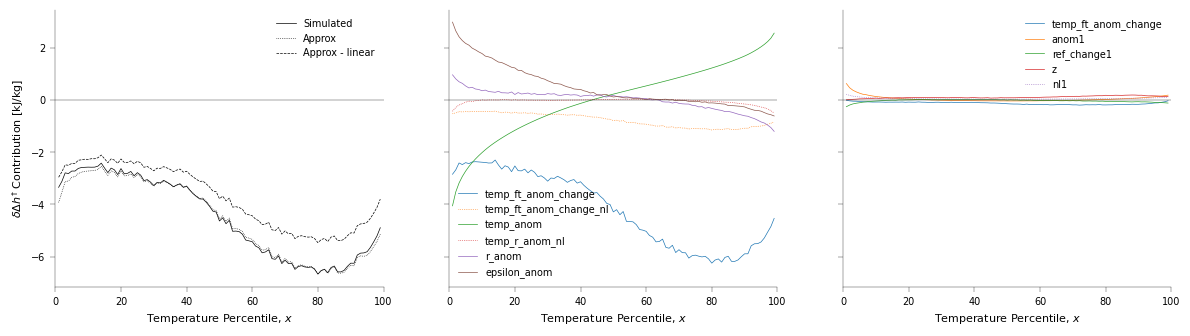

In [745]:
fig, ax = plt.subplots(1,3, figsize=(3*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
ax[0].plot(quant_plot, np.average(np.diff(mse_mod_anom, axis=0).squeeze(), axis=0, weights=lat_weights)/1000, color='k', label='Simulated')
# ax[0].plot(quant_plot, np.average(np.sum(np.array(list(mse_mod_anom_change_cont.values())), axis=0), axis=0, weights=lat_weights)/1000,
#            color='k', linestyle=':')
ax[0].plot(quant_plot, np.average(np.sum(np.array([mse_mod_anom_ft_change_cont[key] for key in mse_mod_anom_ft_change_cont if
                                                   'approx' not in key]), axis=0),
                                  axis=0, weights=lat_weights)/1000, color='k', linestyle=':', label='Approx')
ax[0].plot(quant_plot, np.average(np.sum(np.array([mse_mod_anom_ft_change_cont[key] for key in mse_mod_anom_ft_change_cont if
                                                   ('approx' not in key) and ('nl' not in key)]), axis=0),
                                  axis=0, weights=lat_weights)/1000, color='k', linestyle='--', label='Approx - linear')
for key in mse_mod_anom_ft_change_cont:
    if 'approx' not in key:
        ax[1].plot(quant_plot, np.average(mse_mod_anom_ft_change_cont[key], axis=0, weights=lat_weights) / 1000, label=key,
                   linestyle=':' if 'nl' in key else None)
    else:
        ax[2].plot(quant_plot, np.average(mse_mod_anom_ft_change_cont[key], axis=0, weights=lat_weights) / 1000, label=key.replace('approx_', ''),
                   linestyle=':' if 'nl' in key else None)
for ax_use in ax:
    ax_use.legend()
    ax_use.axhline(0, color='k', lw=ax_linewidth)
    ax_use.set_xlabel('Temperature Percentile, $x$')
# ax[1].plot(quant_plot, np.average(np.diff(approx['s_anom'], axis=0).squeeze()/1000, axis=0, weights=lat_weights), color='k')
# ax[1].axhline(0, color='k', lw=ax_linewidth)
# ax[0].set_ylabel('$\Delta A_{s\Delta}$ [kJ/kg]')
# ax[1].set_ylabel('$\delta \Delta A_{s\Delta}$ [kJ/kg]')
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('$\delta \Delta h^{\dagger}$ Contribution [kJ/kg]')
# if show_plot:
#     plt.show()
# else:
#     plt.close()

## Approximations associated with Surface Derivation of $\delta \Delta h^{\dagger}$
Taking the change with warming of $(S1)$, we get (using $\delta (\tilde{\mu}\tilde{\beta}_{s1}) = \delta \tilde{\beta}_{s1}$):

$$\begin{align}
\delta \Delta h^{\dagger}[x] &= \left[\tilde{\beta}_{s1} + \tilde{\mu}\tilde{\beta}_{s1} \frac{\Delta r_s[x]}{\tilde{r}_s}
+ \left(1 + \frac{\Delta r_s[x]}{\tilde{r}_s}\right) \delta \tilde{\beta}_{s1}
+ (\tilde{\mu}\tilde{\beta}_{s1} + \delta \tilde{\beta}_{s1})\delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\right)\right]\delta \Delta T_s[x] \\
&+ \left[L_v\tilde{q}_s + \delta(L_v \tilde{q}_s) + (\tilde{\mu}\tilde{\beta}_{s1} + \delta \tilde{\beta}_{s1})\Delta T_s[x]\right]
 \delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\right)\\
 &+ \left(1 + \frac{\Delta r_s[x]}{\tilde{r}_s}\right)\Delta T_s[x] \delta \tilde{\beta}_{s1} + \frac{\Delta r_s[x]}{\tilde{r}_s} \delta(L_v \tilde{q}_s)
 - \delta \Delta \epsilon[x] + \delta A_{s\Delta}[x]
 \end{align}\tag{6}$$

We can replace $\delta (L_v \tilde{q}_s)$ using the definition for $\tilde{h}^{\dagger}$, and then using $(S2)$, as well as noting $\tilde{\mu}\tilde{\beta}_{s1} = L_v\tilde{\alpha}_s \tilde{q}_s = \tilde{\beta}_{s1} - (c_p-R^{\dagger})\tilde{T}_s$:

$$\delta (L_v \tilde{q}_s) = \delta \left(\tilde{h}^{\dagger} + \tilde{\epsilon} - (c_p-R^{\dagger})\tilde{T}_s\right)
= \tilde{\mu}\tilde{\beta}_{s1}\left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s} \right)\delta \tilde{T}_s
+ L_v\tilde{q}_s \frac{\delta \tilde{r}_s}{\tilde{r}_s} + \tilde{A}_{s\delta}\tag{7}$$

In [746]:
# Sanity check that equation 7 is correct
# beta_s1[0] - (c_p-R_mod) - mu[0] * beta_s1[0]
sphum_ref_change_eqn = mu[0] * beta_s1[0] * (1 + np.diff(r_ref, axis=0).squeeze()/r_ref[0]) * np.diff(temp_ref[:, ind_surf], axis=0).squeeze() + \
                       L_v * sphum_ref[0] * np.diff(r_ref, axis=0).squeeze()/r_ref[0] + approx['s_ref_change']
sphum_ref_change_eqn = sphum_ref_change_eqn / L_v
print(sphum_ref_change_eqn - np.diff(sphum_ref, axis=0).squeeze())

[ 5.20417043e-18  2.81892565e-17 -3.03576608e-17 -3.59955121e-17
  1.47451495e-17 -1.90819582e-17  1.73472348e-18  3.90312782e-18
  1.73472348e-18  2.16840434e-18 -9.10729825e-18  1.64798730e-17
  3.46944695e-18  3.03576608e-18]


### Approx S3 - Due to non-linear changes with warming
Now lets combine all terms with non-linear changes. We decide that a non-linear term is one with at least 4 combined $\delta$ and $\Delta$ symbols e.g.  $\delta \Delta \chi_1\delta \tilde{\chi}_2 \delta \tilde{\chi}_3$ or $\delta \Delta \chi_1\delta \Delta \chi_2$. We do this as both $\delta$ and $\Delta$ should be small, so when this many multiplied together, should be very small indeed.

$$A_{NL2}[x] = \frac{\Delta r_s[x]}{\tilde{r}_s} \delta \tilde{\beta}_{s1}\delta \Delta T_s[x]
+ \left[\tilde{\mu}\tilde{\beta}_{s1} \frac{\delta \tilde{r}_s}{\tilde{r}_s}\delta\tilde{T}_s + \Delta T_s[x] \delta \tilde{\beta}_{s1}
\right]\delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\right)
+ (\tilde{\mu}\tilde{\beta}_{s1} + \delta \tilde{\beta}_{s1})\delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\right) \delta \Delta T_s[x] \tag{S3}$$

Combining $(6)$, $(7)$ and $(S3)$, we get:

$$\begin{align}
\delta \Delta h^{\dagger}[x] &= \left[\tilde{\beta}_{s1} + \tilde{\mu}\tilde{\beta}_{s1} \frac{\Delta r_s[x]}{\tilde{r}_s}
+ \delta \tilde{\beta}_{s1}\right]\delta \Delta T_s[x]
+ \left[L_v\tilde{q}_s \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) + \tilde{\mu}\tilde{\beta}_{s1}(\Delta T_s[x] + \delta \tilde{T}_s)\right]
 \delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\right)\\
&+ \left(1 + \frac{\Delta r_s[x]}{\tilde{r}_s}\right)\Delta T_s[x] \delta \tilde{\beta}_{s1}
+ \tilde{\mu}\tilde{\beta}_{s1}\left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s} \right) \frac{\Delta r_s[x]}{\tilde{r}_s} \delta \tilde{T}_s
+ L_v\tilde{q}_s \frac{\Delta r_s[x]}{\tilde{r}_s} \frac{\delta \tilde{r}_s}{\tilde{r}_s}
- \delta \Delta \epsilon[x] \\
&+ \left[\frac{\Delta r_s[x]}{\tilde{r}_s}  + \delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s} \right) \right]\tilde{A}_{s\delta}
+ A_{NL2}[x] + \delta A_{s\Delta}[x]
 \end{align}\tag{8}$$

In [747]:
approx['s_nl_temp_cont'] = r_anom[0]/r_ref[0, :, np.newaxis] * np.diff(beta_s1, axis=0).squeeze()[:, np.newaxis] * \
                           np.diff(temp_anom[:, ind_surf], axis=0).squeeze()
approx['s_nl_r_cont'] = (mu[0]*beta_s1[0] * np.diff(r_ref, axis=0).squeeze()/r_ref[0] * np.diff(temp_ref[:, ind_surf], axis=0).squeeze())[:, np.newaxis] \
                        * np.diff(r_anom/r_ref[:, :, np.newaxis], axis=0).squeeze()
approx['s_nl_r_cont'] += np.diff(beta_s1, axis=0).squeeze()[:, np.newaxis] * temp_anom[0, ind_surf] * \
                         np.diff(r_anom/r_ref[:, :, np.newaxis], axis=0).squeeze()
approx['s_nl_temp_r_cont'] = (mu[0]*beta_s1[0] + np.diff(beta_s1, axis=0).squeeze())[:, np.newaxis] * \
                             np.diff(r_anom/r_ref[:, :, np.newaxis], axis=0).squeeze() * np.diff(temp_anom[:, ind_surf], axis=0).squeeze()
approx['s_nl'] = approx['s_nl_temp_cont'] + approx['s_nl_r_cont'] + approx['s_nl_temp_r_cont']

In [748]:
show_plot = False
fig, ax = plt.subplots(1,1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
# ax.plot(quant_plot, np.average(approx['s_temp_nl'], axis=0, weights=lat_weights)/1000, label=labels_exp[i])
# ax.plot(quant_plot, np.average(approx['s_r_nl'], axis=0, weights=lat_weights)/1000, label=labels_exp[i])
ax.plot(quant_plot, np.average(approx['s_nl'], axis=0, weights=lat_weights)/1000, color='k', label='Sum')
ax.plot(quant_plot, np.average(approx['s_nl_temp_cont'], axis=0, weights=lat_weights)/1000, color='k', linestyle='--', label='$\delta \Delta T_s$')
ax.plot(quant_plot, np.average(approx['s_nl_r_cont'], axis=0, weights=lat_weights)/1000, color='k', linestyle=':', label='$\delta \Delta r_s$')
ax.plot(quant_plot, np.average(approx['s_nl_temp_r_cont'], axis=0, weights=lat_weights)/1000, color='k', linestyle='-.',
        label='$\delta \Delta T_s \delta \Delta r_s$')
# ax.plot(quant_plot, np.average(approx['s_nl3'], axis=0, weights=lat_weights)/1000, label=labels_exp[i])
ax.legend()
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_ylabel('$\Delta A_{NL2}$ [kJ/kg]')
ax.set_xlim(0, 100)
ax.set_xlabel('Temperature Percentile, $x$')
if show_plot:
    plt.show()
else:
    plt.close()

### Approx S4 - Due to change in $\tilde{\beta}_{s1}$, $\tilde{A}_{s\beta}$
In an analagous way to $(FT2)$, we can do a linear taylor expansion of $\delta \tilde{\beta}_{s1}$:

$$\delta \tilde{\beta}_{s1} = \tilde{\beta}_{s2}(1 + \tilde{A}_{s\beta}) \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right)
\frac{\delta \tilde{T}_s}{\tilde{T}_s} + \tilde{\mu}\tilde{\beta}_{s1} \frac{\delta \tilde{r}_s}{\tilde{r}_s} \tag{S4}$$

where $\beta_{s2} = T_s \frac{\partial^2h^{\dagger}}{\partial T_s^2} =  T_s\frac{\partial \beta_{s1}}{\partial T_s} =
T_s\frac{\partial (\mu \beta_{s1})}{\partial T_s} = L_v \alpha_s q_s(\alpha_s T_s - 2)$. Again, $\tilde{A}_{s\beta}$ quantifies how accurate this linear approximation is, and it arises due to the non-linear temperature dependence of $q^*$. It is dimensionless. Combining this with $(8)$, we get:

$$\begin{align}
\delta \Delta h^{\dagger}[x] &= \left[\tilde{\beta}_{s1} + \tilde{\mu}\tilde{\beta}_{s1} \left(\frac{\Delta r_s[x]}{\tilde{r}_s}
+ \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) + \tilde{\beta}_{s2} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right)
\frac{\delta \tilde{T}_s}{\tilde{T}_s}\right]\delta \Delta T_s[x]
+ \left[L_v\tilde{q}_s \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) + \tilde{\mu}\tilde{\beta}_{s1}(\Delta T_s[x] + \delta \tilde{T}_s)\right]
 \delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\right)\\
&+ \left[\tilde{\beta}_{s2} \Delta T_s[x] \left(1 + \frac{\Delta r_s[x]}{\tilde{r}_s}\right)
+ \tilde{\mu}\tilde{\beta}_{s1} \tilde{T}_s \frac{\Delta r_s[x]}{\tilde{r}_s} \right] \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right)
\frac{\delta \tilde{T}_s}{\tilde{T}_s}
+ \left[\tilde{\mu}\tilde{\beta}_{s1} \Delta T_s[x] \left(1 + \frac{\Delta r_s[x]}{\tilde{r}_s} \right)
+ L_v \tilde{q}_s \frac{\Delta r_s[x]}{\tilde{r}_s} \right]\frac{\delta \tilde{r}_s}{\tilde{r}_s} - \delta \Delta \epsilon[x] \\
&+ \left[\frac{\Delta r_s[x]}{\tilde{r}_s}  + \delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s} \right) \right]\tilde{A}_{s\delta}
+ A_{NL2}[x] + \delta A_{s\Delta}[x]
+ \left[ \delta \Delta T_s[x]
+ \Delta T_s[x] \left(1 + \frac{\Delta r_s[x]}{\tilde{r}_s}\right) \right]\left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right)
\frac{\delta \tilde{T}_s}{\tilde{T}_s} \tilde{\beta}_{s2} \tilde{A}_{s\beta}
\end{align}\tag{9}$$

Or re-writing, grouping together $\Delta T_s[x]$ and $\Delta r_s[x]$ terms:

$$\begin{align}
\delta \Delta h^{\dagger}[x] &= \left[\tilde{\beta}_{s1} + \tilde{\mu}\tilde{\beta}_{s1} \left(\frac{\Delta r_s[x]}{\tilde{r}_s}
+ \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) + \tilde{\beta}_{s2} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right)
\frac{\delta \tilde{T}_s}{\tilde{T}_s}\right]\delta \Delta T_s[x]
+ \left[L_v\tilde{q}_s \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) + \tilde{\mu}\tilde{\beta}_{s1}(\Delta T_s[x] + \delta \tilde{T}_s)\right]
 \delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\right)\\
&+ \left[\tilde{\beta}_{s2} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \delta \tilde{T}_s
+ \tilde{\mu}\tilde{\beta}_{s1} \tilde{T}_s \frac{\delta \tilde{r}_s}{\tilde{r}_s}  \right]
\left(1 + \frac{\Delta r_s[x]}{\tilde{r}_s} \right)\frac{\Delta T_s[x]}{\tilde{T_s}}
+ \left[\tilde{\mu} \tilde{\beta}_{s1} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \delta \tilde{T}_s
+ L_v \tilde{q}_s \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right]\frac{\Delta r_s[x]}{\tilde{r}_s}\\
&+ \tilde{A}_{\delta 2}[x] + \delta A_{s\Delta}[x] + A_{NL2}[x]
\end{align}\tag{10}$$

where we have combined approximations due to changes in the reference day:

$$
\tilde{A}_{\delta 2}[x] = \left[\frac{\Delta r_s[x]}{\tilde{r}_s}  + \delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s} \right) \right]\tilde{A}_{s\delta}
+ \left[ \delta \Delta T_s[x] + \Delta T_s[x] \left(1 + \frac{\Delta r_s[x]}{\tilde{r}_s}\right) \right]
\left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \frac{\delta \tilde{T}_s}{\tilde{T}_s} \tilde{\beta}_{s2} \tilde{A}_{s\beta}
$$

In [749]:
approx['s_beta'] = (np.diff(beta_s1, axis=0).squeeze() - mu[0] * beta_s1[0] * np.diff(r_ref, axis=0).squeeze()/r_ref[0]) \
                   * temp_ref[0, ind_surf] / np.diff(temp_ref[:, ind_surf],axis=0).squeeze() / (1 + np.diff(r_ref, axis=0).squeeze()/r_ref[0]) \
                   /beta_s2[0] - 1
print('A_s_beta = {:.3g}'.format(np.average(approx['s_beta'], axis=0, weights=lat_weights)))

A_s_beta = 0.182


### Approx S5 - Due to $\Delta \chi_1 \delta \Delta \chi_2$ Terms
This approximation is fairly significant, but makes for much easier interpretation, and can always point to this approximation later. As well as only having addition of linear terms in final equation when we come to $\delta \Delta T_s$ equation.

$$A_{NL3}[x] = \tilde{\mu}\tilde{\beta}_{s1} \frac{\Delta r_s[x]}{\tilde{r}_s} \delta \Delta T_s[x]
+ \tilde{\mu}\tilde{\beta}_{s1}\Delta T_s[x]
 \delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\right) \tag{S5}$$

Using this, $(10)$ becomes:

$$\begin{align}
\delta \Delta h^{\dagger}[x] &= \left[\tilde{\beta}_{s1} + \tilde{\mu}\tilde{\beta}_{s1} \frac{\delta \tilde{r}_s}{\tilde{r}_s} + \tilde{\beta}_{s2} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right)
\frac{\delta \tilde{T}_s}{\tilde{T}_s}\right]\delta \Delta T_s[x]
+ \left[L_v\tilde{q}_s \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) + \tilde{\mu}\tilde{\beta}_{s1}\delta \tilde{T}_s\right]
 \delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\right)\\
&+ \left[\tilde{\beta}_{s2} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \delta \tilde{T}_s
+ \tilde{\mu}\tilde{\beta}_{s1} \tilde{T}_s \frac{\delta \tilde{r}_s}{\tilde{r}_s}  \right]
\left(1 + \frac{\Delta r_s[x]}{\tilde{r}_s} \right)\frac{\Delta T_s[x]}{\tilde{T_s}}
+ \left[\tilde{\mu} \tilde{\beta}_{s1} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \delta \tilde{T}_s
+ L_v \tilde{q}_s \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right]\frac{\Delta r_s[x]}{\tilde{r}_s}\\
&+ \tilde{A}_{\delta 2}[x] + \delta A_{s\Delta}[x] + A_{NL2}[x] + A_{NL3}[x]
\end{align}\tag{11}$$

In [750]:
approx['nl3_temp_change'] = (mu[0] * beta_s1[0])[:, np.newaxis] * r_anom[0]/r_ref[0, :, np.newaxis] * np.diff(temp_anom[:, ind_surf], axis=0).squeeze()
approx['nl3_r_change'] = (mu[0] * beta_s1[0])[:, np.newaxis] * temp_anom[0, ind_surf] * np.diff(r_anom/r_ref[:, :, np.newaxis], axis=0).squeeze()
approx['nl3'] = approx['nl3_temp_change'] + approx['nl3_r_change']

In [751]:
show_plot = False
fig, ax = plt.subplots(1,1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
ax.plot(quant_plot, np.average(approx['nl3'], axis=0, weights=lat_weights)/1000, color='k', label='Sum')
ax.plot(quant_plot, np.average(approx['nl3_temp_change'], axis=0, weights=lat_weights)/1000, color='k', linestyle='--', label='$\Delta r_s \delta \Delta T_s$')
ax.plot(quant_plot, np.average(approx['nl3_r_change'], axis=0, weights=lat_weights)/1000, color='k', linestyle=':', label='$\Delta T_s \delta \Delta r_s$')
# Plot \delta A_{s\Delta} as cancels with this term
ax.plot(quant_plot, -np.average(np.diff(approx['s_anom'], axis=0).squeeze(), axis=0, weights=lat_weights)/1000, color='r', label='$-\delta A_{s\Delta}$')
ax.legend()
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_ylabel('$A_{NL3}$ [kJ/kg]')
ax.set_xlim(0, 100)
ax.set_xlabel('Temperature Percentile, $x$')
if show_plot:
    plt.show()
else:
    plt.close()

In [752]:
mse_mod_anom_s_change_cont = {
    'temp_s_anom_change': beta_s1[0][:, np.newaxis] * np.diff(temp_anom[:, ind_surf], axis=0).squeeze(),
    'temp_s_anom_change_nl': (mu[0] * beta_s1[0] * (np.diff(r_ref, axis=0).squeeze()/r_ref[0])
                                     + beta_s2[0] * np.diff(temp_ref[:, ind_surf], axis=0).squeeze() / temp_ref[0, ind_surf] *
                             (1 + (np.diff(r_ref, axis=0).squeeze()/r_ref[0])))[:, np.newaxis] * np.diff(temp_anom[:, ind_surf], axis=0).squeeze(),
    'r_anom_change': L_v * sphum_ref[0, :, np.newaxis] * np.diff(r_anom/r_ref[:, :, np.newaxis], axis=0).squeeze(),
    'r_anom_change_nl': (mu[0] * beta_s1[0] * np.diff(temp_ref[:, ind_surf], axis=0).squeeze() +
                           L_v * sphum_ref[0] * np.diff(r_ref, axis=0).squeeze() / r_ref[0])[:, np.newaxis] *
                          np.diff(r_anom/r_ref[:, :, np.newaxis], axis=0).squeeze(),
    'temp_anom': (beta_s2[0] * (1 + np.diff(r_ref, axis=0).squeeze()/r_ref[0]) * np.diff(temp_ref[:, ind_surf], axis=0).squeeze()/temp_ref[0, ind_surf]
              + mu[0] * beta_s1[0] * np.diff(r_ref, axis=0).squeeze() / r_ref[0])[:, np.newaxis] * temp_anom[0, ind_surf],
    'r_anom': (mu[0] * beta_s1[0] * (1 + np.diff(r_ref, axis=0).squeeze()/r_ref[0]) * np.diff(temp_ref[:, ind_surf], axis=0).squeeze()
              + L_v * sphum_ref[0] * np.diff(r_ref, axis=0).squeeze()/r_ref[0])[:, np.newaxis] * r_anom[0]/r_ref[0, :, np.newaxis],
    'epsilon_anom_change': -np.diff(epsilon_anom, axis=0).squeeze()
}
mse_mod_anom_s_change_cont['temp_r_anom_nl'] = mse_mod_anom_s_change_cont['temp_anom'] * r_anom[0] / r_ref[0, :, np.newaxis]

# Approx terms
# Contribution to ref change error from change A_{s\delta}
mse_mod_anom_s_change_cont['approx_ref_change2'] = approx['s_ref_change'][:, np.newaxis] * (r_anom[0]/r_ref[0, :, np.newaxis] +
                                                                                       np.diff(r_anom/r_ref[:, :, np.newaxis], axis=0).squeeze())
# Contribution to ref change error from change in beta
mse_mod_anom_s_change_cont['approx_ref_change2'] += (beta_s2[0] * approx['s_beta'] * (1 + np.diff(r_ref, axis=0).squeeze()/r_ref[0]) *
                                             np.diff(temp_ref[:, ind_surf], axis=0).squeeze()/temp_ref[0, ind_surf])[:, np.newaxis] *  \
                                            (np.diff(temp_anom[:, ind_surf], axis=0).squeeze() + temp_anom[0, ind_surf] *
                                             (1 + r_anom[0]/r_ref[0, :, np.newaxis]))
mse_mod_anom_s_change_cont['approx_nl2'] = approx['s_nl'] * 1
mse_mod_anom_s_change_cont['approx_nl3'] = approx['nl3'] * 1
mse_mod_anom_s_change_cont['approx_temp_s_anom_change'] = np.diff(approx['s_anom'], axis=0).squeeze()


In [753]:
# Sanity check that sum of all terms is equal to actual MSE mod anom change
print('Max Diff: {:.2g}'.format(np.abs(np.sum(np.array(list(mse_mod_anom_s_change_cont.values())), axis=0) -
                                       np.diff(mse_mod_anom, axis=0).squeeze()).max()))

Max Diff: 4.9e-11


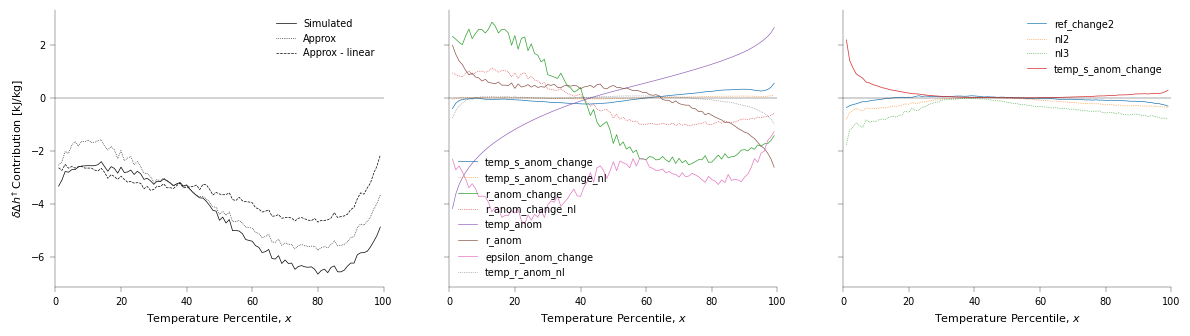

In [754]:
fig, ax = plt.subplots(1,3, figsize=(3*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
ax[0].plot(quant_plot, np.average(np.diff(mse_mod_anom, axis=0).squeeze(), axis=0, weights=lat_weights)/1000, color='k', label='Simulated')
ax[0].plot(quant_plot, np.average(np.sum(np.array([mse_mod_anom_s_change_cont[key] for key in mse_mod_anom_s_change_cont if
                                                   'approx' not in key]), axis=0),
                                  axis=0, weights=lat_weights)/1000, color='k', linestyle=':', label='Approx')
ax[0].plot(quant_plot, np.average(np.sum(np.array([mse_mod_anom_s_change_cont[key] for key in mse_mod_anom_s_change_cont if
                                                   ('approx' not in key) and ('nl' not in key)]), axis=0),
                                  axis=0, weights=lat_weights)/1000, color='k', linestyle='--', label='Approx - linear')
for key in mse_mod_anom_s_change_cont:
    if 'approx' not in key:
        ax[1].plot(quant_plot, np.average(mse_mod_anom_s_change_cont[key], axis=0, weights=lat_weights) / 1000, label=key,
                   linestyle=':' if 'nl' in key else None)
    else:
        ax[2].plot(quant_plot, np.average(mse_mod_anom_s_change_cont[key], axis=0, weights=lat_weights) / 1000, label=key.replace('approx_', ''),
                   linestyle=':' if 'nl' in key else None)
for ax_use in ax:
    ax_use.legend()
    ax_use.axhline(0, color='k', lw=ax_linewidth)
    ax_use.set_xlabel('Temperature Percentile, $x$')
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('$\delta \Delta h^{\dagger}$ Contribution [kJ/kg]')
plt.show()
# if show_plot:
#     plt.show()
# else:
#     plt.close()

## Equation for $\delta \Delta T_s(x)$
Equating our two equations for $\delta \Delta h^{\dagger}[x]$, we can get an equation for $\delta \Delta T_s(x)$:

$$\begin{align}
\tilde{\beta}_{s1}\delta \Delta T_s(x) =
&-\left[\tilde{\mu} \frac{\delta \tilde{r}_s}{\tilde{r}_s} +
\frac{\tilde{\beta}_{s2}}{\tilde{\beta}_{s1}} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \frac{\delta \tilde{T}_s}{\tilde{T}_s}\right]
\tilde{\beta}_{s1} \delta \Delta T_s[x] + \left(1 + \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}}
\frac{\delta \tilde{h}^{\dagger}_0}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}\right) \tilde{\beta}_{FT1} \delta \Delta T'_{FT}[x] \\
&-\left[L_v\tilde{q}_s \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) + \tilde{\mu}\tilde{\beta}_{s1}\delta \tilde{T}_s\right]
\delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\right) + \delta \Delta \epsilon[x] \\
&+ \left[\frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\tilde{\beta}_{s1} \tilde{T}_s}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\delta \tilde{h}^{\dagger}_0
- \tilde{\beta}_{s2} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \delta \tilde{T}_s
-\tilde{\mu}\tilde{\beta}_{s1} \tilde{T}_s \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right]\frac{\Delta T_s[x]}{\tilde{T_s}} \\
&+ \left[\tilde{\mu}\frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\tilde{\beta}_{s1} \tilde{T}_s}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\delta \tilde{h}^{\dagger}_0
- \tilde{\beta}_{s2} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \delta \tilde{T}_s
-\tilde{\mu}\tilde{\beta}_{s1} \tilde{T}_s \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right]
\frac{\Delta r_s[x]}{\tilde{r_s}}\frac{\Delta T_s[x]}{\tilde{T_s}} \\
&+ \left[\frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{L_v \tilde{q}_s}{\tilde{\beta}_{FT1}\tilde{T}_{FT}} \delta \tilde{h}^{\dagger}_0
- \tilde{\mu} \tilde{\beta}_{s1} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \delta \tilde{T}_s
- L_v \tilde{q}_s \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right] \frac{\Delta r_s[x]}{\tilde{r_s}} \\
&+ \delta A_{FT\Delta}[x] + A_{\Delta 1}[x] + \tilde{A}_{\delta 1}[x] + A'_z[x] + A_{NL1}[x]
- \tilde{A}_{\delta 2}[x] - \delta A_{s\Delta}[x] - A_{NL2}[x] - A_{NL3}[x]
\end{align}\tag{12}$$

### Approx NL4 - Assume $\delta \tilde{\chi_1}\delta \Delta \chi_2[x]$ terms small
Combining these terms, we get (again can be a significant error):

$$A_{NL4} = -\left[\tilde{\mu} \frac{\delta \tilde{r}_s}{\tilde{r}_s} +
\frac{\tilde{\beta}_{s2}}{\tilde{\beta}_{s1}} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \frac{\delta \tilde{T}_s}{\tilde{T}_s}\right]
\tilde{\beta}_{s1} \delta \Delta T_s[x]
+ \frac{\delta \tilde{h}^{\dagger}_0}{\tilde{\beta}_{FT1}\tilde{T}_{FT}} \tilde{\beta}_{FT2} \delta \Delta T_{FT}'[x]
-\left[L_v\tilde{q}_s \frac{\delta \tilde{r}_s}{\tilde{r}_s} + \tilde{\mu}\tilde{\beta}_{s1}\delta \tilde{T}_s\right]
\delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\right)$$

Combining this with $(12)$ gives:

$$\begin{align}
\tilde{\beta}_{s1}\delta \Delta T_s(x) &=
\tilde{\beta}_{FT1} \delta \Delta T_{FT}'[x] - \left[L_v\tilde{q}_s + \tilde{\mu}\tilde{\beta}_{s1} \Delta T_s[x] \right]
\delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\right) + \delta \Delta \epsilon[x] \\
&+ \left[\frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\tilde{\beta}_{s1} \tilde{T}_s}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\delta \tilde{h}^{\dagger}_0
- \tilde{\beta}_{s2} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \delta \tilde{T}_s
-\tilde{\mu}\tilde{\beta}_{s1} \tilde{T}_s \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right]\frac{\Delta T_s[x]}{\tilde{T_s}} \\
&+ \left[\tilde{\mu}\frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\tilde{\beta}_{s1} \tilde{T}_s}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\delta \tilde{h}^{\dagger}_0
- \tilde{\beta}_{s2} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \delta \tilde{T}_s
-\tilde{\mu}\tilde{\beta}_{s1} \tilde{T}_s \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right]
\frac{\Delta r_s[x]}{\tilde{r_s}}\frac{\Delta T_s[x]}{\tilde{T_s}} \\
&+ \left[\frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{L_v \tilde{q}_s}{\tilde{\beta}_{FT1}\tilde{T}_{FT}} \delta \tilde{h}^{\dagger}_0
- \tilde{\mu} \tilde{\beta}_{s1} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \delta \tilde{T}_s
- L_v \tilde{q}_s \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right] \frac{\Delta r_s[x]}{\tilde{r_s}} \\
&- \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\delta \tilde{h}^{\dagger}_0}{\tilde{\beta}_{FT1}\tilde{T}_{FT}} \Delta \epsilon[x] \\
&+ \delta A_{FT\Delta}[x] + A_{\Delta 1}[x] + \tilde{A}_{\delta 1}[x] + A'_z[x] + A_{NL1}[x]
- \tilde{A}_{\delta 2}[x] - \delta A_{s\Delta}[x] - A_{NL2}[x] - A_{NL3}[x] + A_{NL4}[x]
\end{align}\tag{13}$$

### Final approximate theory for $\frac{\delta \Delta T_s(x)}{\delta \overline{T}_s}$
Taking $(12)$, neglecting the approximations, and choosing the reference day to satisfy:
* $\tilde{T}_s = \overline{T_s}; \delta \tilde{T}_s = \delta \overline{T_s}$
* $\tilde{r}_s = \overline{r_s}; \delta \tilde{r}_s = 0$
* $\tilde{\epsilon} = 0; \delta \tilde{\epsilon} = 0$

We can get our final theory:

$$\begin{align}
\left(1 + \tilde{\mu} \frac{\Delta r_s[x]}{\tilde{r}_s} \right) \frac{\delta \Delta T_s(x)}{\delta \tilde{T}_s} &=
\frac{\tilde{\beta}_{FT1}}{\tilde{\beta}_{s1}} \frac{\delta T_{FT}[x]}{\delta \tilde{T}_s} - 1
- \left[\frac{L_v\tilde{q}_s}{\tilde{\beta}_{s1} \tilde{T}_s} + \tilde{\mu} \frac{\Delta T_s[x]}{\tilde{T}_s} \right]
\frac{\tilde{T}_s}{\tilde{r}_s} \frac{\delta r_s[x]}{\delta \tilde{T}_s} + \frac{\delta \epsilon[x]}{\tilde{\beta}_{s1} \delta \tilde{T}_s} \\
&+ \left[\frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\tilde{\beta}_{s1} \tilde{T}_s}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
- \frac{\tilde{\beta}_{s2}}{\tilde{\beta}_{s1}}\right]\frac{\Delta T_s[x]}{\tilde{T_s}} \\
&+ \left[\tilde{\mu}\frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\tilde{\beta}_{s1} \tilde{T}_s}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
- \frac{\tilde{\beta}_{s2}}{\tilde{\beta}_{s1}}\right]
\frac{\Delta r_s[x]}{\tilde{r_s}}\frac{\Delta T_s[x]}{\tilde{T_s}} \\
&+ \left[\frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{L_v \tilde{q}_s}{\tilde{\beta}_{FT1}\tilde{T}_{FT}} - \tilde{\mu}\right]
\frac{\Delta r_s[x]}{\tilde{r_s}} \\
&- \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\tilde{\beta}_{s1} \tilde{T}_s}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\frac{\epsilon[x]}{\tilde{\beta}_{s1} \tilde{T}_s}
\end{align}\tag{13}$$

In [755]:
approx['nl4'] = mse_mod_anom_ft_change_cont['temp_ft_anom_change_nl']-mse_mod_anom_s_change_cont['temp_s_anom_change_nl']- \
                mse_mod_anom_s_change_cont['r_anom_change_nl']

In [756]:
show_plot = False
fig, ax = plt.subplots(1,1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
ax.plot(quant_plot, np.average(approx['nl4'], axis=0, weights=lat_weights)/1000, color='k', label='Sum')
ax.plot(quant_plot, np.average(mse_mod_anom_ft_change_cont['temp_ft_anom_change_nl'], axis=0, weights=lat_weights)/1000,
        color='k', linestyle='--', label="$\delta \Delta T'_{FT}$")
ax.plot(quant_plot, np.average(-mse_mod_anom_s_change_cont['temp_s_anom_change_nl'], axis=0, weights=lat_weights)/1000,
        color='k', linestyle=':', label='$-\delta \Delta T_s$')
ax.plot(quant_plot, np.average(-mse_mod_anom_s_change_cont['r_anom_change_nl'], axis=0, weights=lat_weights)/1000,
        color='k', linestyle='-.', label='$-\delta \Delta r_s$')
# Plot \delta A_{FT\Delta} as cancels with this term
ax.plot(quant_plot, -np.average(mse_mod_anom_ft_change_cont['approx_temp_ft_anom_change'], axis=0, weights=lat_weights)/1000,
        label='-$\delta A_{FT\Delta}$', color='r')
ax.legend()
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_ylabel('$A_{NL4}$ [kJ/kg]')
ax.set_xlim(0, 100)
ax.set_xlabel('Temperature Percentile, $x$')
if show_plot:
    plt.show()
else:
    plt.close()

### Approx $\Delta2$ - Assume $\Delta \chi_1[x] \Delta \chi_2[x]$ terms small

$$A_{\Delta 2}[x] = \left[\tilde{\mu}\frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\tilde{\beta}_{s1} \tilde{T}_s}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\delta \tilde{h}^{\dagger}_0
- \tilde{\beta}_{s2} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \delta \tilde{T}_s
-\tilde{\mu}\tilde{\beta}_{s1} \tilde{T}_s \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right]
\frac{\Delta r_s[x]}{\tilde{r_s}}\frac{\Delta T_s[x]}{\tilde{T_s}}$$

Combining the equations for $A_{NL4}$ and $A_{\Delta 2}$ with $(12)$ gives:

$$\begin{align}
\tilde{\beta}_{s1}\delta \Delta T_s(x) &=
\tilde{\beta}_{FT1} \delta \Delta T_{FT}'[x] - \left[L_v\tilde{q}_s + \tilde{\mu}\tilde{\beta}_{s1} \Delta T_s[x] \right]
\delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\right) + \delta \Delta \epsilon[x] \\
&+ \left[\frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\tilde{\beta}_{s1} \tilde{T}_s}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\delta \tilde{h}^{\dagger}_0
- \tilde{\beta}_{s2} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \delta \tilde{T}_s
-\tilde{\mu}\tilde{\beta}_{s1} \tilde{T}_s \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right]\frac{\Delta T_s[x]}{\tilde{T_s}} \\
&+ \left[\frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{L_v \tilde{q}_s}{\tilde{\beta}_{FT1}\tilde{T}_{FT}} \delta \tilde{h}^{\dagger}_0
- \tilde{\mu} \tilde{\beta}_{s1} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \delta \tilde{T}_s
- L_v \tilde{q}_s \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right] \frac{\Delta r_s[x]}{\tilde{r_s}} \\
&- \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\delta \tilde{h}^{\dagger}_0}{\tilde{\beta}_{FT1}\tilde{T}_{FT}} \Delta \epsilon[x] \\
&+ \delta A_{FT\Delta}[x] + A_{\Delta 1}[x] + \tilde{A}_{\delta 1}[x] + A'_z[x] + A_{NL1}[x]
- \tilde{A}_{\delta 2}[x] - \delta A_{s\Delta}[x] - A_{NL2}[x] - A_{NL3}[x] + A_{NL4}[x] + A_{\Delta 2}[x]
\end{align}\tag{13}$$

### Final approximate theory for $\frac{\delta T_s(x)}{\delta \overline{T}_s}$
Taking $(12)$, neglecting the approximations, and choosing the reference day to satisfy:
* $\tilde{T}_s = \overline{T_s}; \delta \tilde{T}_s = \delta \overline{T_s}$
* $\tilde{r}_s = \overline{r_s}; \delta \tilde{r}_s = 0$
* $\tilde{\epsilon} = 0; \delta \tilde{\epsilon} = 0$

We can get our final approximate theory:

$$\begin{align}
\frac{\delta T_s(x)}{\delta \tilde{T}_s} &=
\frac{\tilde{\beta}_{FT1}}{\tilde{\beta}_{s1}} \frac{\delta T_{FT}[x]}{\delta \tilde{T}_s}
- \left[\frac{L_v\tilde{q}_s}{\tilde{\beta}_{s1} \tilde{T}_s} + \tilde{\mu} \frac{\Delta T_s[x]}{\tilde{T}_s} \right]
\frac{\tilde{T}_s}{\tilde{r}_s} \frac{\delta r_s[x]}{\delta \tilde{T}_s} + \frac{\delta \epsilon[x]}{\tilde{\beta}_{s1} \delta \tilde{T}_s} \\
&+ \left[\frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\tilde{\beta}_{s1} \tilde{T}_s}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
- \frac{\tilde{\beta}_{s2}}{\tilde{\beta}_{s1}}\right]\frac{\Delta T_s[x]}{\tilde{T_s}}
- \left[\tilde{\mu} - \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{L_v \tilde{q}_s}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}\right]
\frac{\Delta r_s[x]}{\tilde{r_s}}
- \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\tilde{\beta}_{s1} \tilde{T}_s}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\frac{\epsilon[x]}{\tilde{\beta}_{s1} \tilde{T}_s}
\end{align}\tag{13}$$

In [757]:
approx['anom2'] = mse_mod_anom_ft_change_cont['temp_r_anom_nl'] - mse_mod_anom_s_change_cont['temp_r_anom_nl']

In [758]:
show_plot = False
fig, ax = plt.subplots(1,1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True)
ax.plot(quant_plot, np.average(approx['anom2'], axis=0, weights=lat_weights)/1000, color='k', label='Sum')
ax.plot(quant_plot, np.average(mse_mod_anom_ft_change_cont['temp_r_anom_nl'], axis=0, weights=lat_weights)/1000,
        color='k', linestyle='--', label="FT Expansion")
ax.plot(quant_plot, np.average(-mse_mod_anom_s_change_cont['temp_r_anom_nl'], axis=0, weights=lat_weights)/1000,
        color='k', linestyle=':', label='Surface Expansion')
ax.legend()
ax.axhline(0, color='k', lw=ax_linewidth)
ax.set_ylabel('$A_{\Delta 2}$ [kJ/kg]')
ax.set_xlim(0, 100)
ax.set_xlabel('Temperature Percentile, $x$')
if show_plot:
    plt.show()
else:
    plt.close()

In [759]:
temp_anom_change_sim = mse_mod_anom_s_change_cont['temp_s_anom_change'] * 1
temp_anom_change_cont = {}
for key in mse_mod_anom_ft_change_cont:
    if key in ['temp_ft_anom_change_nl', 'temp_r_anom_nl']:
        # Included in approx_nl4 or approx_anom2
        continue
    temp_anom_change_cont[key] = 1 * mse_mod_anom_ft_change_cont[key]       # 1* to stop updating mse_mod_anom_ft_change_cont dict

for key in mse_mod_anom_s_change_cont:
    if key in ['temp_s_anom_change_nl', 'temp_s_anom_change', 'r_anom_change_nl', 'temp_r_anom_nl']:
        # Included in approx_nl4, approx_anom2 or in temp_anom_change_sim
        continue
    if key in temp_anom_change_cont:
        temp_anom_change_cont[key] -= mse_mod_anom_s_change_cont[key]
    else:
        temp_anom_change_cont[key] = -mse_mod_anom_s_change_cont[key]
temp_anom_change_cont['approx_nl4'] = approx['nl4'] * 1
temp_anom_change_cont['approx_anom2'] = approx['anom2'] * 1

In [760]:
print('Max Diff: {:.2g}'.format(np.abs(np.sum(np.array(list(temp_anom_change_cont.values())), axis=0) -
                                       temp_anom_change_sim).max()))

Max Diff: 4.8e-11


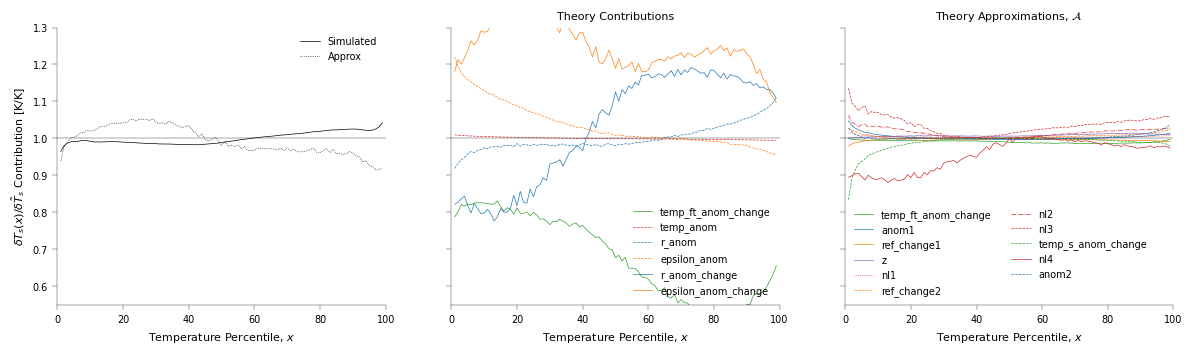

In [761]:
colors_cont = {'temp_ft_anom_change': default_colors[2], 'temp_ft_change': default_colors[2],
               'temp_anom': default_colors[3], 'r_anom': default_colors[0],
               'r_anom_change': default_colors[0], 'r_change': default_colors[0],
               'epsilon_anom': default_colors[1], 'epsilon_anom_change': default_colors[1],
               'epsilon_change': default_colors[1], 'r_ref_change': default_colors[4]}
linestyle_cont = {key: ('-' if 'change' in key else '--') for key in colors_cont}
colors_approx = {'temp_ft_anom_change': default_colors[2], 'temp_s_anom_change': default_colors[2],
                 'anom1': default_colors[0], 'anom2': default_colors[0], 'anom': default_colors[0], 'anom_temp_s_r': default_colors[0],
                 'ref_change': default_colors[1], 'ref_change1': default_colors[1], 'ref_change2': default_colors[1], 'nl': default_colors[3],
                 'nl1': default_colors[3], 'nl2': default_colors[3], 'nl3': default_colors[3], 'nl4': default_colors[3], 'z': default_colors[4],
                 'z_anom_change': default_colors[4], 'r_anom_change': default_colors[0], 'r_change': default_colors[0],
                 'temp_s_anom_r_change': default_colors[2]}
linestyle_approx = {'temp_ft_anom_change': None, 'temp_s_anom_change': '--', 'anom1': None, 'anom2': '--', 'anom': '--','anom_temp_s_r':':',
                    'ref_change': None, 'ref_change1': None, 'ref_change2': '--', 'nl': ':', 'nl1': ':', 'nl2': '-.', 'nl3': '--', 'nl4': None,
                    'z': None, 'z_anom_change': None, 'r_anom_change': None, 'r_change': None, 'temp_s_anom_r_change': ':'}

sf_simulated = temp_anom_change_sim/(beta_s1[0]*np.diff(temp_ref[:, ind_surf], axis=0).squeeze())[:, np.newaxis] + 1
fig, ax = plt.subplots(1,3, figsize=(3*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
ax[0].plot(quant_plot, np.average(sf_simulated, axis=0, weights=lat_weights), color='k', label='Simulated')
ax[0].plot(quant_plot, 1+np.average(np.sum(np.array([temp_anom_change_cont[key] for key in temp_anom_change_cont if 'approx' not in key]), axis=0)
                                    /(beta_s1[0]*np.diff(temp_ref[:, ind_surf], axis=0).squeeze())[:, np.newaxis],
                                    axis=0, weights=lat_weights), color='k', linestyle=':', label='Approx')
# Mulitply sum by mu term so it cancels with LHS of eqn 12
# ax[0].plot(quant_plot, np.average(np.sum(np.array([temp_anom_change_cont[key] for key in temp_anom_change_cont if
#                                                    ('approx' not in key) and ('nl' not in key)])/beta_s1[0,:,np.newaxis], axis=0),
#                                   axis=0, weights=lat_weights)/1000, color='k', linestyle='--', label='Approx - linear')

for key in temp_anom_change_cont:
    if 'approx' not in key:
        ax[1].plot(quant_plot, 1+np.average(temp_anom_change_cont[key]/(beta_s1[0]*np.diff(temp_ref[:, ind_surf], axis=0).squeeze())[:, np.newaxis],
                                            axis=0, weights=lat_weights) , label=key,
                   linestyle=linestyle_cont[key], color=colors_cont[key])
    else:
        ax[2].plot(quant_plot, 1+np.average(temp_anom_change_cont[key]/(beta_s1[0]*np.diff(temp_ref[:, ind_surf], axis=0).squeeze())[:, np.newaxis],
                                            axis=0, weights=lat_weights),
                   label=key.replace('approx_', ''), color=colors_approx[key.replace('approx_', '')],
                   linestyle=linestyle_approx[key.replace('approx_', '')])

for i, ax_use in enumerate(ax):
    ax_use.legend(ncol=2 if i==2 else 1)
    ax_use.axhline(1, color='k', lw=ax_linewidth)
    ax_use.set_xlabel('Temperature Percentile, $x$')
ax[0].set_xlim(0, 100)
ax[1].set_title('Theory Contributions')
ax[2].set_title('Theory Approximations, $\mathcal{A}$')
ax[0].set_ylabel('$\delta T_s(x)/\delta \\tilde{T}_s$ Contribution [K/K]')
if use_av_as_ref:
    ax[0].set_ylim(0.8, 1.2)
else:
    ax[0].set_ylim(0.55, 1.3)
plt.show()
# isca_tools.savefig(fig)

## Reformulation of Approx Terms
I want to reformulate my approximations so that they are grouped by what is causing the predomenant variation with $x$.

### FT Derivation
In the FT derivation, I group terms according to the following. Note that $A_{FT\Delta}[x] = \sum_{n=2}^{\infty}\frac{1}{n!}\frac{\partial^n h^{\dagger}}{\partial T_{FT}^n}(\Delta T_{FT})^n$.

$$\begin{align}
A_{\delta \Delta T_{FT}} &= \delta A_{FT\Delta}[x] + \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}}
\frac{\tilde{\beta}_{FT1} \delta \Delta T_{FT}'[x]}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
(1 + \tilde{A}_{FT\beta})(\delta \tilde{h}^{\dagger}_0 + \tilde{A}_{s\delta} - \tilde{A}_{FT\delta} - \delta \tilde{A}_{z})\\
A_{\delta \Delta z} &= \delta \Delta A_z[x] \\
A_{\Delta 1}[x] &= \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{1}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\left(\delta \tilde{h}^{\dagger}_0(A_{s\Delta}[x] - A_{FT\Delta}[x] - \Delta A_{z}[x]) + \Delta h^{\dagger}_0[x]
\left(\delta \tilde{h}^{\dagger}_0 \tilde{A}_{FT\beta} + (1 + \tilde{A}_{FT\beta})(\tilde{A}_{s\delta} - \tilde{A}_{FT\delta} - \delta \tilde{A}_{z})
\right)\right) \\
A_{\Delta T\Delta r1}[x] &= \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\delta \tilde{h}^{\dagger}_0}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\tilde{\mu} \tilde{\beta}_{s1}\frac{\Delta r_s[x]}{\tilde{r}_s}\Delta T_s[x] \\
\tilde{A}_{\delta} &= -(\tilde{A}_{s\delta} - \tilde{A}_{FT\delta} - \delta \tilde{A}_{z})\
- \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}}\frac{1}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
(1+\tilde{A}_{FT\beta})(\tilde{A}_{s\delta} - \tilde{A}_{FT\delta} - \delta \tilde{A}_{z})
(\delta \tilde{h}^{\dagger}_0 + \tilde{A}_{s\delta} - \tilde{A}_{FT\delta} - \delta \tilde{A}_{z}) \\
A_{NL}[x] &= \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{1}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\left(\delta \tilde{h}^{\dagger}_0 \tilde{A}_{FT\beta}
+ (1 + \tilde{A}_{FT\beta})(\tilde{A}_{s\delta} - \tilde{A}_{FT\delta} - \delta \tilde{A}_{z})\right)
(A_{s\Delta}[x] - A_{FT\Delta}[x] - \Delta A_z[x])
\end{align}$$

With these approximations, our final equation derived from FT is:

$$
\begin{align}
\delta \Delta h^{\dagger}[x] &= \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{1}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\left(\tilde{\beta}_{s1}\left(1 + \tilde{\mu}\frac{\delta \tilde{r}_s}{\tilde{r}_s}\right)\delta \tilde{T}_s
+ L_v \tilde{q}_s\frac{\delta \tilde{r}_s}{\tilde{r}_s} - \delta \tilde{\epsilon} \right)
\left(\tilde{\beta}_{s1}\Delta T_s[x]
+ L_v \tilde{q}_s\frac{\Delta r_s[x]}{\tilde{r}_s} - \Delta \epsilon[x]\right) \\
&+ \tilde{\beta}_{FT1}\delta T_{FT}[x]
-  \left(\tilde{\beta}_{s1}\left(1 + \tilde{\mu}\frac{\delta \tilde{r}_s}{\tilde{r}_s}\right)\delta \tilde{T}_s
+ L_v \tilde{q}_s\frac{\delta \tilde{r}_s}{\tilde{r}_s} - \delta \tilde{\epsilon} \right)\\
&+ A_{\delta \Delta T_{FT}} + A_{\delta \Delta z} + A_{\Delta 1}[x] + A_{\Delta T\Delta r1}[x] + \tilde{A}_{\delta} + A_{NL}[x]
 \end{align}\tag{14}$$

In [762]:
# First just give linear taylor series terms
mse_mod_anom_ft_change_cont2 = {'temp_ft_anom_change': beta_ft1[0][:, np.newaxis] * temp_ft_anom_change_mod,
                      'temp_anom': (prefactor_mse_ft * mse_mod_ref_change0 * beta_s1[0])[:, np.newaxis] * temp_anom[0, ind_surf],
                      'r_anom': (prefactor_mse_ft * mse_mod_ref_change0 * L_v * sphum_ref[0])[:, np.newaxis] *
                                  (r_anom[0]/r_ref[0, :, np.newaxis]),
                      'epsilon_anom': -(prefactor_mse_ft * mse_mod_ref_change0)[:, np.newaxis] * epsilon_anom[0]}

var_ref_change2 = approx['s_ref_change'] - approx['ft_ref_change'] - np.diff(approx['z_ref'], axis=0).squeeze()
var_anom0 = approx['s_anom'][0] - approx['ft_anom'][0] - approx['z_anom'][0]

mse_mod_anom_ft_change_cont2['approx_temp_ft_anom_change'] = np.diff(approx['ft_anom'], axis=0).squeeze()
mse_mod_anom_ft_change_cont2['approx_temp_ft_anom_change'] += (prefactor_mse_ft * beta_ft1[0] * (1+approx['ft_beta']) * (
        mse_mod_ref_change0 + var_ref_change2))[:, np.newaxis] * temp_ft_anom_change_mod

mse_mod_anom_ft_change_cont2['approx_z_anom_change'] = np.diff(approx['z_anom'], axis=0).squeeze()

mse_mod_anom_ft_change_cont2['approx_anom1'] = (prefactor_mse_ft * mse_mod_ref_change0)[:, np.newaxis] * (var_anom0 + approx['ft_beta'][:, np.newaxis]
                                                                                                          * mse_mod_anom0)
mse_mod_anom_ft_change_cont2['approx_anom1'] += (prefactor_mse_ft * (1+approx['ft_beta']) * var_ref_change2)[:, np.newaxis] * mse_mod_anom0

mse_mod_anom_ft_change_cont2['approx_anom_temp_r1'] = (prefactor_mse_ft * mse_mod_ref_change0 * beta_s1[0])[:, np.newaxis] * (
        mu[0, :, np.newaxis] * (r_anom[0]/r_ref[0, :, np.newaxis])) * temp_anom[0, ind_surf]


mse_mod_anom_ft_change_cont2['approx_ref_change'] = -var_ref_change2 - prefactor_mse_ft * (1+approx['ft_beta']) * var_ref_change2 * (
        mse_mod_ref_change0 + var_ref_change2)
mse_mod_anom_ft_change_cont2['approx_ref_change'] = np.tile(mse_mod_anom_ft_change_cont2['approx_ref_change'][:, np.newaxis], [1, n_quant])

mse_mod_anom_ft_change_cont2['approx_nl'] = (prefactor_mse_ft * ((approx['ft_beta'] * mse_mod_ref_change0) + (1+approx['ft_beta']) * var_ref_change2)
                                              )[:, np.newaxis] * var_anom0

In [763]:
print('Max Diff: {:.2g}'.format(np.abs(np.sum(np.array(list(mse_mod_anom_ft_change_cont2.values())), axis=0) -
                                       np.diff(mse_mod_anom, axis=0).squeeze()).max()))

Max Diff: 5.5e-12


Text(0, 0.5, '$\\delta \\Delta h^{\\dagger}$ Contribution [kJ/kg]')

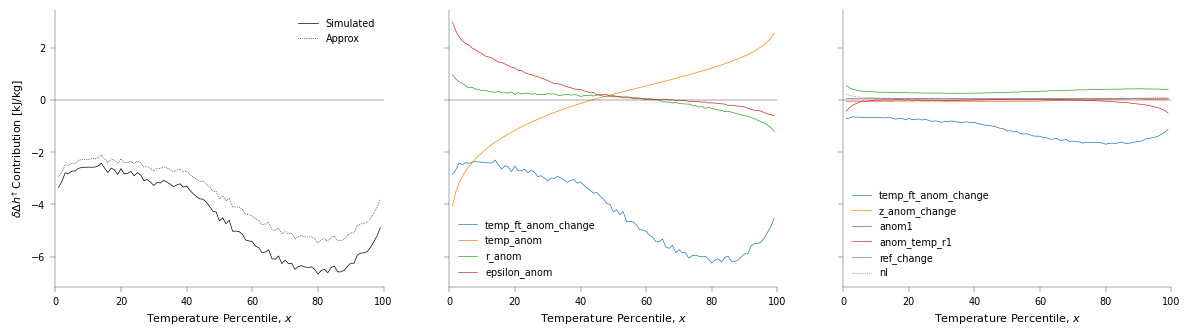

In [764]:
fig, ax = plt.subplots(1,3, figsize=(3*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
ax[0].plot(quant_plot, np.average(np.diff(mse_mod_anom, axis=0).squeeze(), axis=0, weights=lat_weights)/1000, color='k', label='Simulated')
# ax[0].plot(quant_plot, np.average(np.sum(np.array(list(mse_mod_anom_change_cont.values())), axis=0), axis=0, weights=lat_weights)/1000,
#            color='k', linestyle=':')
ax[0].plot(quant_plot, np.average(np.sum(np.array([mse_mod_anom_ft_change_cont2[key] for key in mse_mod_anom_ft_change_cont2 if
                                                   'approx' not in key]), axis=0),
                                  axis=0, weights=lat_weights)/1000, color='k', linestyle=':', label='Approx')
for key in mse_mod_anom_ft_change_cont2:
    if 'approx' not in key:
        ax[1].plot(quant_plot, np.average(mse_mod_anom_ft_change_cont2[key], axis=0, weights=lat_weights) / 1000, label=key,
                   linestyle=':' if 'nl' in key else None)
    else:
        ax[2].plot(quant_plot, np.average(mse_mod_anom_ft_change_cont2[key], axis=0, weights=lat_weights) / 1000, label=key.replace('approx_', ''),
                   linestyle=':' if 'nl' in key else None)
for ax_use in ax:
    ax_use.legend()
    ax_use.axhline(0, color='k', lw=ax_linewidth)
    ax_use.set_xlabel('Temperature Percentile, $x$')
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('$\delta \Delta h^{\dagger}$ Contribution [kJ/kg]')

 ### From Surface Derivation
Let us group together terms we later neglect involving $\delta \Delta \chi$ and $\Delta \chi_1 \Delta \chi_2$ contributions. Note in the following, we use the equality $\delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\right) = \delta \left(\frac{r_s[x]}{\tilde{r}_s}\right)$.

Note that
$A_{s\Delta}[x] = (1 + \frac{\Delta r_s[x]}{\tilde{r}_s})\sum_{n=2}^{\infty}\frac{1}{n!}\frac{\partial^n h^{\dagger}}{\partial T_{s}^n}(\Delta T_{s})^n
= (1 + \frac{\Delta r_s[x]}{\tilde{r}_s})A_{s\Delta T}[x]$ so we can split $\delta A_{s\Delta}[x]$ into contribution from temperature, relative humidity and a non-linear term:

$\delta A_{s\Delta}[x] = (1 + \frac{\Delta r_s[x]}{\tilde{r}_s})\delta A_{s\Delta T}[x] +
A_{s\Delta T}[x] \delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\right) + \delta A_{s\Delta T}[x] \delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\right)$

Doing this, we get:

$$\begin{align}
A_{\delta \Delta T_s}[x] &= \left(1 + \frac{\Delta r_s[x]}{\tilde{r}_s}\right)\delta A_{s\Delta T}[x] + \left[\tilde{\mu}\tilde{\beta}_{s1} \frac{\Delta r_s[x]}{\tilde{r}_s}
+ \left(1 + \frac{\Delta r_s[x]}{\tilde{r}_s}\right) \delta \tilde{\beta}_{s1}\right]\delta \Delta T_s[x] \\
A_{\delta r1}[x] &= \left(A_{s\Delta T}[x] + \delta(L_v \tilde{q}_s) + (\tilde{\mu}\tilde{\beta}_{s1} + \delta \tilde{\beta}_{s1})\Delta T_s[x]\right)
\delta \left(\frac{r_s[x]}{\tilde{r}_s}\right)\\
A_{\delta \Delta T_s\delta r}[x] &= \delta A_{s\Delta T}[x] \delta \left(\frac{r_s[x]}{\tilde{r}_s}\right)
+ (\tilde{\mu}\tilde{\beta}_{s1} + \delta \tilde{\beta}_{s1})\delta \left(\frac{r_s[x]}{\tilde{r}_s}\right)\delta \Delta T_s[x] \\
A_{\Delta T\Delta r2}[x] &= \delta \tilde{\beta}_{s1}\frac{\Delta r_s[x]}{\tilde{r}_s} \Delta T_s[x]
 \end{align}$$

Using the above, $(6)$ becomes:

$$\begin{align}
\delta \Delta h^{\dagger}[x] &= \tilde{\beta}_{s1} \delta \Delta T_s[x] + L_v\tilde{q}_s \delta \left(\frac{r_s[x]}{\tilde{r}_s}\right)
+ \Delta T_s[x] \delta \tilde{\beta}_{s1} + \frac{\Delta r_s[x]}{\tilde{r}_s} \delta(L_v \tilde{q}_s)
- \delta \Delta \epsilon[x] \\
&+ A_{\delta \Delta T_s}[x] + A_{\delta r1}[x] + A_{\delta \Delta T_s\delta r}[x] + A_{\Delta T\Delta r2}[x]
 \end{align}\tag{6}$$

Applying $(7)$ and $(S4)$ gives:

$$\begin{align}
\delta \Delta h^{\dagger}[x] &= \tilde{\beta}_{s1} \delta \Delta T_s[x] + L_v\tilde{q}_s \delta \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\right)
- \delta \Delta \epsilon[x] \\
&+ \Delta T_s[x]
\left(\tilde{\beta}_{s2}(1 + \tilde{A}_{s\beta}) \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right)
\frac{\delta \tilde{T}_s}{\tilde{T}_s} + \tilde{\mu}\tilde{\beta}_{s1} \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \\
&+ \frac{\Delta r_s[x]}{\tilde{r}_s}
\left(\tilde{\mu}\tilde{\beta}_{s1}\left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s} \right)\delta \tilde{T}_s
+ L_v\tilde{q}_s \frac{\delta \tilde{r}_s}{\tilde{r}_s} + \tilde{A}_{s\delta}\right) \\
&+ A_{\delta \Delta T_s}[x] + A_{\delta \Delta r1}[x] + A_{\delta \Delta T_s\delta \Delta r}[x] + A_{\Delta T\Delta r2}[x]
 \end{align}$$


Grouping the remaing $A$ terms together as $A_{\Delta 2}$, we get:

$$
A_{\Delta 2}[x] =  \tilde{A}_{s\beta} \tilde{\beta}_{s2} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right)
\frac{\delta \tilde{T}_s}{\tilde{T}_s} \Delta T_s[x] + \tilde{A}_{s\delta} \frac{\Delta r_s[x]}{\tilde{r}_s}
$$

We also want to re-write the relative humidity change term, to neglect the change in the reference relative humidity:

$$
L_v\tilde{q}_s \delta \left(\frac{r_s[x]}{\tilde{r}_s}\right) = L_v\tilde{q}_s \left[\frac{\delta r_s[x]}{\tilde{r}_s}
- \left(1+\frac{\Delta r_s[x]}{\tilde{r}_s}\right)\frac{\delta \tilde{r}_s}{\tilde{r}_s}\right] + A_{\delta r2}[x]
$$

where $A_{\delta r2}[x] = 0$ if $\delta \tilde{r}_s=0$, and is also given by the following:

$$
\frac{A_{\delta r2}[x]}{L_v\tilde{q}_s} = \left(\frac{1}{1+\frac{\delta \tilde{r}_s}{\tilde{r}_s}} - 1\right)\frac{\delta r_s[x]}{\tilde{r}_s}
+ \left(\frac{1}{1+\frac{\delta \tilde{r}_s}{\tilde{r}_s}} - 1
+ \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right)\left(1 + \frac{\Delta r_s[x]}{\tilde{r}_s}\right)
$$

Combining the two $A_{\delta r}$ term together, we get:

$$
A_{\delta r}[x] = A_{\delta r1}[x] + A_{\delta r2}[x] =
\left(A_{s\Delta T}[x] + L_v \tilde{q}_s + \delta(L_v \tilde{q}_s) + (\tilde{\mu}\tilde{\beta}_{s1} + \delta \tilde{\beta}_{s1})\Delta T_s[x]\right)
\delta \left(\frac{r_s[x]}{\tilde{r}_s}\right)
+ L_v\tilde{q}_s \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\frac{\delta \tilde{r}_s}{\tilde{r}_s} - \frac{\delta \Delta r_s[x]}{\tilde{r}_s}\right)
$$

This gives our final equation derived from the surface:

$$\begin{align}
\delta \Delta h^{\dagger}[x] &= -L_v\tilde{q}_s\frac{\delta \tilde{r}_s}{\tilde{r}_s} + \tilde{\beta}_{s1} \delta \Delta T_s[x]
+ L_v\tilde{q}_s \frac{\delta r_s[x]}{\tilde{r}_s} - \delta \Delta \epsilon[x] \\
&+ \Delta T_s[x]
\left(\tilde{\beta}_{s2} \left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right)
\frac{\delta \tilde{T}_s}{\tilde{T}_s} + \tilde{\mu}\tilde{\beta}_{s1} \frac{\delta \tilde{r}_s}{\tilde{r}_s}\right) \\
&+ \frac{\Delta r_s[x]}{\tilde{r}_s}
\tilde{\mu}\tilde{\beta}_{s1}\left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s} \right)\delta \tilde{T}_s \\
&+ A_{\delta \Delta T_s}[x] + A_{\delta r}[x] + A_{\delta \Delta T_s\delta r}[x] + A_{\Delta T\Delta r2}[x] + A_{\Delta 2}[x]
\end{align}\tag{15}$$

In [765]:
# Sanity check that equation for temperature contribution of s_anom is correct
mse_mod_anom_const_rh = (moist_static_energy(temp_quant3[:, ind_surf], r_ref[:, :, np.newaxis] * sphum_sat(temp_quant3[:, ind_surf], p_surface), height=0, c_p_const=c_p-R_mod) - epsilon_quant3) * 1000
mse_mod_anom_const_rh = mse_mod_anom_const_rh - mse_mod_ref[:, :, np.newaxis]
approx['s_anom_temp_cont'] = mse_mod_anom_const_rh - beta_s1[:, :, np.newaxis] * (1 + mu[:, :, np.newaxis] * (0*r_anom/r_ref[:, :, np.newaxis])) * temp_anom[:, ind_surf] - \
                             L_v * sphum_ref[:, :, np.newaxis] * (0*r_anom/r_ref[:, :, np.newaxis]) + epsilon_anom
# a2 = (approx['s_anom'] - a) / (r_anom/r_ref[:, :, np.newaxis])
approx['s_anom_temp_cont_eqn'] = approx['s_anom']/(1+(r_anom/r_ref[:, :, np.newaxis]))
print('{:.5g}'.format(np.abs(approx['s_anom_temp_cont']-approx['s_anom_temp_cont_eqn']).max()))

1.3631e-10


In [766]:
# Sanity check that decomposition of approx['s_anom_change'] is correct
approx['s_anom_change'] = np.diff(approx['s_anom'], axis=0).squeeze()
approx['s_anom_change_temp_cont'] = (1 + (r_anom/r_ref[:, :, np.newaxis])[0]) * np.diff(approx['s_anom_temp_cont_eqn'], axis=0).squeeze()
approx['s_anom_change_r_cont'] = np.diff((r_anom/r_ref[:, :, np.newaxis]), axis=0).squeeze() * approx['s_anom_temp_cont_eqn'][0]
approx['s_anom_change_temp_r_cont'] = np.diff((r_anom/r_ref[:, :, np.newaxis]), axis=0).squeeze() * np.diff(approx['s_anom_temp_cont_eqn'], axis=0).squeeze()
print('{:.5g}'.format(np.abs(approx['s_anom_change']-approx['s_anom_change_temp_cont']-approx['s_anom_change_r_cont']-approx['s_anom_change_temp_r_cont']).max()))

1.4211e-12


In [767]:
show_plot = False
fig, ax = plt.subplots(1,1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
ax.plot(quant_plot, np.average(approx['s_anom_change'], axis=0, weights=lat_weights) / 1000, color='k', label='Sum')
ax.plot(quant_plot, np.average(approx['s_anom_change_temp_cont'], axis=0, weights=lat_weights) / 1000, color=default_colors[3], label='$T_s$')
ax.plot(quant_plot, np.average(approx['s_anom_change_r_cont'], axis=0, weights=lat_weights) / 1000, label='$r_s$', color=default_colors[0])
ax.plot(quant_plot, np.average(approx['s_anom_change_temp_r_cont'], axis=0, weights=lat_weights) / 1000, label='$T_s r_s$', color=default_colors[1])
ax.legend()
ax.set_ylabel('$\delta A_{s\\Delta}$ Decomposition [kJ/kg]')
if show_plot:
    plt.show()
else:
    plt.close()

In [768]:
mse_mod_anom_s_change_cont2 = {
    'temp_s_anom_change': beta_s1[0][:, np.newaxis] * np.diff(temp_anom[:, ind_surf], axis=0).squeeze(),
    'r_anom_change': L_v * sphum_ref[0, :, np.newaxis] * np.diff(r_quant3, axis=0).squeeze()/r_ref[0, :, np.newaxis],
    'temp_anom': (beta_s2[0] * (1 + np.diff(r_ref, axis=0).squeeze()/r_ref[0]) * np.diff(temp_ref[:, ind_surf], axis=0).squeeze()/temp_ref[0, ind_surf]
              + mu[0] * beta_s1[0] * np.diff(r_ref, axis=0).squeeze() / r_ref[0])[:, np.newaxis] * temp_anom[0, ind_surf],
    'r_anom': (mu[0] * beta_s1[0] * (1 + np.diff(r_ref, axis=0).squeeze()/r_ref[0]) * np.diff(temp_ref[:, ind_surf], axis=0).squeeze()
              + 0*L_v * sphum_ref[0] * np.diff(r_ref, axis=0).squeeze()/r_ref[0])[:, np.newaxis] * r_anom[0]/r_ref[0, :, np.newaxis],
    'epsilon_anom_change': -np.diff(epsilon_anom, axis=0).squeeze(),
    'r_ref_change': -L_v * sphum_ref[0] * np.diff(r_ref, axis=0).squeeze() / r_ref[0]
}
mse_mod_anom_s_change_cont2['r_ref_change'] = np.tile(mse_mod_anom_s_change_cont2['r_ref_change'][:, np.newaxis], [1, n_quant])

mse_mod_anom_s_change_cont2['approx_temp_s_anom_change'] = approx['s_anom_change_temp_cont'] + (
    (mu*beta_s1/r_ref)[0, :, np.newaxis]*r_anom[0] + (1+r_anom[0]/r_ref[0, :, np.newaxis])*np.diff(beta_s1, axis=0).squeeze()[:, np.newaxis]
)* np.diff(temp_anom[:, ind_surf], axis=0).squeeze()

# r_change1 term
mse_mod_anom_s_change_cont2['approx_r_change'] = (L_v * np.diff(sphum_ref, axis=0).squeeze()[:, np.newaxis] +
                                                       (mu[0]*beta_s1[0] + np.diff(beta_s1, axis=0).squeeze())[:, np.newaxis] * temp_anom[0, ind_surf]
                                                       ) * np.diff(r_anom/r_ref[:, :, np.newaxis], axis=0).squeeze() + approx['s_anom_change_r_cont']
# Add r_change2 term
mse_mod_anom_s_change_cont2['approx_r_change'] += L_v * sphum_ref[0][:, np.newaxis] * (
    np.diff(r_anom/r_ref[:, :, np.newaxis], axis=0).squeeze() + r_anom[0] * (np.diff(r_ref, axis=0).squeeze()/r_ref[0]**2)[:, np.newaxis]
    - np.diff(r_anom, axis=0).squeeze()/r_ref[0, :, np.newaxis])

mse_mod_anom_s_change_cont2['approx_temp_s_anom_r_change'] = (mu[0]*beta_s1[0] + np.diff(beta_s1, axis=0).squeeze())[:, np.newaxis] * \
                                                             np.diff(r_anom/r_ref[:, :, np.newaxis], axis=0).squeeze() * \
                                                             np.diff(temp_anom[:, ind_surf], axis=0).squeeze() + approx['s_anom_change_temp_r_cont']

mse_mod_anom_s_change_cont2['approx_anom_temp_r2'] = np.diff(beta_s1, axis=0).squeeze()[:, np.newaxis] * \
                                                      r_anom[0]/r_ref[0, :, np.newaxis] * temp_anom[0, ind_surf]

mse_mod_anom_s_change_cont2['approx_anom2'] = (approx['s_beta'] * beta_s2[0] * (1 + np.diff(r_ref, axis=0).squeeze()/r_ref[0]) *
                                               np.diff(temp_ref[:, ind_surf], axis=0).squeeze()/temp_ref[0, ind_surf]
                                               )[:, np.newaxis] * temp_anom[0, ind_surf] + (approx['s_ref_change']/r_ref[0])[:, np.newaxis] * r_anom[0]

In [769]:
# Sanity check that sum of all terms is equal to actual MSE mod anom change
print('Max Diff: {:.2g}'.format(np.abs(np.sum(np.array(list(mse_mod_anom_s_change_cont2.values())), axis=0) -
                                       np.diff(mse_mod_anom, axis=0).squeeze()).max()))

Max Diff: 3.3e-11


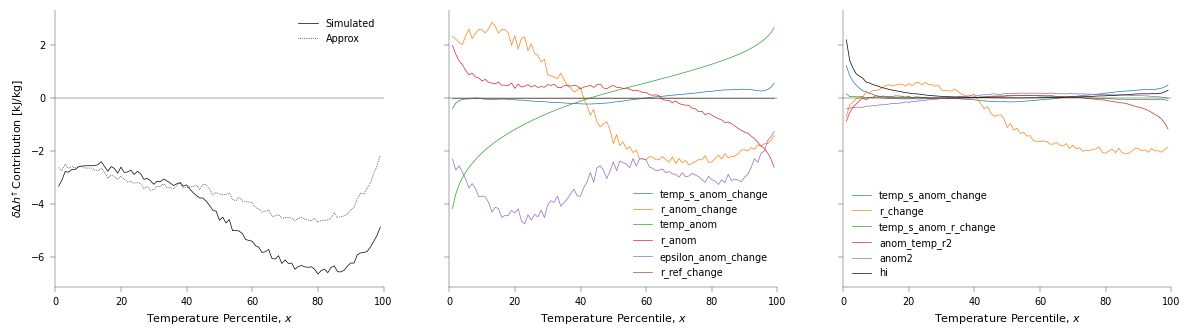

In [770]:
fig, ax = plt.subplots(1,3, figsize=(3*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
ax[0].plot(quant_plot, np.average(np.diff(mse_mod_anom, axis=0).squeeze(), axis=0, weights=lat_weights)/1000, color='k', label='Simulated')
ax[0].plot(quant_plot, np.average(np.sum(np.array([mse_mod_anom_s_change_cont2[key] for key in mse_mod_anom_s_change_cont2 if
                                                   'approx' not in key]), axis=0),
                                  axis=0, weights=lat_weights)/1000, color='k', linestyle=':', label='Approx')
for key in mse_mod_anom_s_change_cont2:
    if 'approx' not in key:
        ax[1].plot(quant_plot, np.average(mse_mod_anom_s_change_cont2[key], axis=0, weights=lat_weights) / 1000, label=key,
                   linestyle=':' if 'nl' in key else None)
    else:
        ax[2].plot(quant_plot, np.average(mse_mod_anom_s_change_cont2[key], axis=0, weights=lat_weights) / 1000, label=key.replace('approx_', ''),
                   linestyle=':' if 'nl' in key else None)
ax[2].plot(quant_plot, np.average(np.diff(approx['s_anom'], axis=0).squeeze(), axis=0, weights=lat_weights) / 1000, color='k', label='hi')
# ax[2].plot(quant_plot, np.average((
#     (mu*beta_s1/r_ref)[0, :, np.newaxis]*r_anom[0] + 0*(1+r_anom[0]/r_ref[0, :, np.newaxis])*np.diff(beta_s1, axis=0).squeeze()[:, np.newaxis]
# )* np.diff(temp_anom[:, ind_surf], axis=0).squeeze(), axis=0, weights=lat_weights) / 1000, color='k', label='hi2', linestyle=':')
# ax[2].plot(quant_plot, np.average((mu[0]*beta_s1[0] + 0*np.diff(beta_s1, axis=0).squeeze())[:, np.newaxis] * temp_anom[0, ind_surf] * np.diff(r_anom/r_ref[:, :, np.newaxis], axis=0).squeeze(), axis=0, weights=lat_weights) / 1000, color='k', label='hi')
# ax[2].plot(quant_plot, np.average(L_v * np.diff(sphum_ref, axis=0).squeeze()[:, np.newaxis] * np.diff(r_anom/r_ref[:, :, np.newaxis], axis=0).squeeze(), axis=0, weights=lat_weights) / 1000, color='k', label='hi2', linestyle='--')
for ax_use in ax:
    ax_use.legend()
    ax_use.axhline(0, color='k', lw=ax_linewidth)
    ax_use.set_xlabel('Temperature Percentile, $x$')
ax[0].set_xlim(0, 100)
ax[0].set_ylabel('$\delta \Delta h^{\dagger}$ Contribution [kJ/kg]')
plt.show()

### Scaling Factor
By equating $(14)$ and $(15)$, we can get our final equation for the scaling factor, $\delta T_s(x)/\delta \tilde{T}_s$:

$$\begin{align}
\frac{\delta T_s(x)}{\delta \tilde{T}_s} &= -\tilde{\mu} \frac{\delta \tilde{r}_s}{\tilde{r}_s}
+ \frac{\tilde{\beta}_{FT1}}{\tilde{\beta}_{s1}} \frac{\delta T_{FT}[x]}{\delta \tilde{T}_s}
- \frac{L_v\tilde{q}_s}{\tilde{\beta}_{s1} \tilde{T}_s} \frac{\tilde{T}_s}{\tilde{r}_s} \frac{\delta r_s[x]}{\delta \tilde{T}_s}
+ \frac{\delta \epsilon[x]}{\tilde{\beta}_{s1} \delta \tilde{T}_s} \\
&+ \left[\frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{1}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\left(\tilde{T}_s \frac{\delta \tilde{h}^{\dagger}_0}{\delta \tilde{T}_s}\right)
- \frac{\tilde{\beta}_{s2}}{\tilde{\beta}_{s1}}\left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s} \right)
- \tilde{\mu} \frac{\tilde{T}_s}{\tilde{r}_s} \frac{\delta \tilde{r}_s}{\delta \tilde{T}_s}\right]\frac{\Delta T_s[x]}{\tilde{T_s}} \\
&- \left[\tilde{\mu}\left(1 + \frac{\delta \tilde{r}_s}{\tilde{r}_s} \right)
- \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}}
\frac{1}{\tilde{\beta}_{FT1}\tilde{T}_{FT}} \left(\tilde{T}_s \frac{\delta \tilde{h}^{\dagger}_0}{\delta \tilde{T}_s}\right)
\frac{L_v \tilde{q}_s}{\tilde{\beta}_{s1}\tilde{T}_{s}}\right]
\frac{\Delta r_s[x]}{\tilde{r_s}} \\
&- \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{1}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\left(\tilde{T}_s \frac{\delta \tilde{h}^{\dagger}_0}{\delta \tilde{T}_s}\right)
\frac{\Delta \epsilon[x]}{\tilde{\beta}_{s1} \tilde{T}_s} \\
&+ A_{\delta \Delta T_{FT}} + A_{\delta \Delta z} + A_{\Delta 1}[x] + A_{\Delta T\Delta r1}[x] + \tilde{A}_{\delta} + A_{NL}[x] \\
&- A_{\delta \Delta T_s}[x] - A_{\delta r}[x] - A_{\delta \Delta T_s\delta r}[x] - A_{\Delta T\Delta r2}[x] - A_{\Delta 2}[x]
\end{align}\tag{16}$$

In [771]:
temp_anom_change_cont2 = {'approx_anom': mse_mod_anom_ft_change_cont2['approx_anom1'] - mse_mod_anom_s_change_cont2['approx_anom2'],
                          'approx_anom_temp_s_r': mse_mod_anom_ft_change_cont2['approx_anom_temp_r1'] -
                                                 mse_mod_anom_s_change_cont2['approx_anom_temp_r2']}
for key in mse_mod_anom_ft_change_cont2:
    if key in ['approx_anom_temp_r1', 'approx_anom_temp_r2', 'approx_anom1', 'approx_anom2', 'temp_s_anom_change']:
        continue
    temp_anom_change_cont2[key] = 1 * mse_mod_anom_ft_change_cont2[key]       # 1* to stop updating mse_mod_anom_ft_change_cont dict

for key in mse_mod_anom_s_change_cont2:
    if key in ['approx_anom_temp_r1', 'approx_anom_temp_r2', 'approx_anom1', 'approx_anom2', 'temp_s_anom_change']:
        continue
    if key in temp_anom_change_cont2:
        temp_anom_change_cont2[key] -= mse_mod_anom_s_change_cont2[key]       # 1* to stop updating mse_mod_anom_ft_change_cont dict
    else:
        temp_anom_change_cont2[key] = -mse_mod_anom_s_change_cont2[key]

print('Max Diff: {:.2g}'.format(np.abs(np.sum(np.array(list(temp_anom_change_cont2.values())), axis=0) -
                                       temp_anom_change_sim).max()))

Max Diff: 3.3e-11


In [772]:
# Group temp_anom_change_cont2 together so match that of get_scale_factor_theory function
sf_theory = np.sum(np.array([temp_anom_change_cont2[key] for key in temp_anom_change_cont2 if 'approx' not in key]
                            ), axis=0)/(beta_s1[0]*np.diff(temp_ref[:, ind_surf], axis=0).squeeze())[:, np.newaxis] + 1
sf_theory_cont = {}
sf_theory_cont['temp_ft_change'] = temp_anom_change_cont2['temp_ft_anom_change'] + mse_mod_ref_change0[:, np.newaxis]
sf_theory_cont['r_change'] = temp_anom_change_cont2['r_anom_change'] * 1
sf_theory_cont['epsilon_change'] = np.diff(epsilon_quant3, axis=0).squeeze()*1000
sf_theory_cont['temp_anom'] = temp_anom_change_cont2['temp_anom'] * 1
sf_theory_cont['r_anom'] = temp_anom_change_cont2['r_anom'] * 1
sf_theory_cont['epsilon_anom'] = temp_anom_change_cont2['epsilon_anom'] * 1
for key in sf_theory_cont:
    sf_theory_cont[key] *= 1/(beta_s1[0]*np.diff(temp_ref[:, ind_surf], axis=0).squeeze())[:, np.newaxis]
sf_theory_cont['r_ref_change'] = -mu[0] * np.diff(r_ref, axis=0).squeeze() / r_ref[0]
sf_theory_cont['r_ref_change'] = np.tile(sf_theory_cont['r_ref_change'][:, np.newaxis], [1, n_quant])
print('Max Diff: {:.2g}'.format(np.abs(np.sum(np.array(list(sf_theory_cont.values())), axis=0) -
                                       sf_theory).max()))    # sanity check that sum of contributions equal theory

Max Diff: 6.7e-16


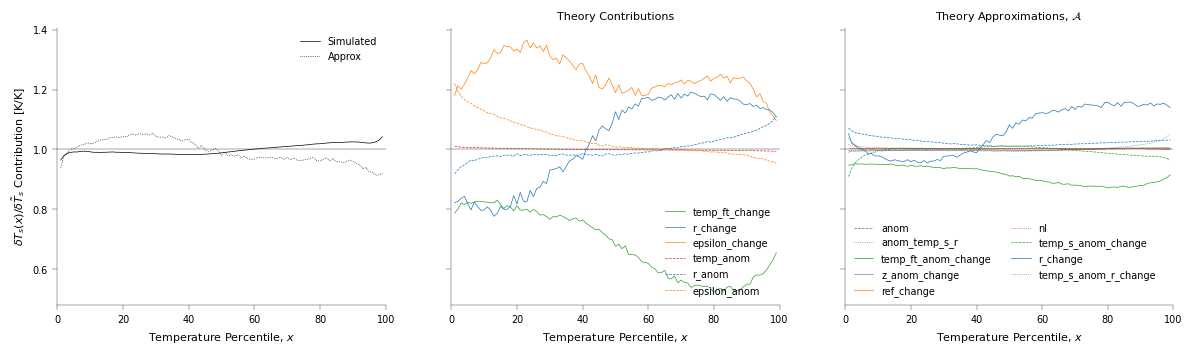

In [773]:
fig, ax = plt.subplots(1,3, figsize=(3*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
ax[0].plot(quant_plot, np.average(sf_simulated, axis=0, weights=lat_weights), color='k', label='Simulated')
ax[0].plot(quant_plot, np.average(sf_theory, axis=0, weights=lat_weights), color='k', linestyle=':', label='Approx')

for key in sf_theory_cont:
    if (not use_av_as_ref) and (key == 'r_ref_change'):
        continue
    ax[1].plot(quant_plot, (0 if key=='temp_ft_change' else 1) + np.average(sf_theory_cont[key], axis=0, weights=lat_weights),
               label=key, linestyle=linestyle_cont[key], color=colors_cont[key])

for key in temp_anom_change_cont2:
    if 'approx' in key:
        ax[2].plot(quant_plot, 1+np.average(temp_anom_change_cont2[key]/(beta_s1[0]*np.diff(temp_ref[:, ind_surf], axis=0).squeeze())[:, np.newaxis],
                                            axis=0, weights=lat_weights),
                   label=key.replace('approx_', ''), color=colors_approx[key.replace('approx_', '')],
                   linestyle=linestyle_approx[key.replace('approx_', '')])

for i, ax_use in enumerate(ax):
    ax_use.legend(ncol=2 if i==2 else 1)
    ax_use.axhline(1, color='k', lw=ax_linewidth)
    ax_use.set_xlabel('Temperature Percentile, $x$')
ax[0].set_xlim(0, 100)
ax[1].set_title('Theory Contributions')
ax[2].set_title('Theory Approximations, $\mathcal{A}$')
ax[0].set_ylabel('$\delta T_s(x)/\delta \\tilde{T}_s$ Contribution [K/K]')
# if use_av_as_ref:
#     ax[0].set_ylim(0.8, 1.2)
# else:
#     ax[0].set_ylim(0.55, 1.3)
plt.show()
# isca_tools.savefig(fig)

In [774]:
# Sanity check that get_approx_terms function in adiabat_theory2.py gives same result as this
sf_approx_breakdown_func = {key.replace('approx_', ''): np.zeros((n_lat, n_quant)) for key in temp_anom_change_cont2 if 'approx' in key}
approx_from_func = {}
for i in range(n_lat):
    var_use = get_approx_terms(temp_ref[:, ind_surf, i], temp_quant3[:, ind_surf, i], r_ref[:, i], r_quant3[:, i],
                               temp_quant3[:, ind_ft, i], epsilon_quant3[:, i], p_surface, pressure_ft_actual,
                               epsilon_ref[:, i], z_approx_error_ref[:, i])
    for key in var_use[0]:
        sf_approx_breakdown_func[key][i] = var_use[0][key]
    for key in var_use[1]:
        if key not in approx_from_func:
            approx_from_func[key] = [var_use[1][key]]
        else:
            approx_from_func[key] += [var_use[1][key]]
print('Approx SF Terms')
for key in sf_approx_breakdown_func:
    print(key + ': {:.5g}'.format(np.max(np.abs(sf_approx_breakdown_func[key] - temp_anom_change_cont2['approx_'+key]/(beta_s1[0]*np.diff(temp_ref[:, ind_surf], axis=0).squeeze())[:, np.newaxis]))))

print('\nIndividual Approx')
for key in approx_from_func:
    approx_from_func[key] = np.asarray(approx_from_func[key])
    if len(approx_from_func[key].shape)>1 and approx_from_func[key].shape[1] == n_kappa:
        if 'ref' in key:
            approx_from_func[key] = np.transpose(approx_from_func[key], [1, 0])
        else:
            approx_from_func[key] = np.transpose(approx_from_func[key], [1, 0, 2])
    print(key + ': {:.5g}'.format(np.max(np.abs(approx_from_func[key] - approx[key]))))

Approx SF Terms
anom: 0
anom_temp_s_r: 1.3878e-17
temp_ft_anom_change: 0
z_anom_change: 4.3802e-15
ref_change: 0
nl: 0
temp_s_anom_change: 4.4131e-15
r_change: 9.7145e-16
temp_s_anom_r_change: 9.7491e-16

Individual Approx
z_quant: 5.8208e-11
z_ref: 0
z_anom: 5.8208e-11
ft_anom: 0
ft_beta: 0
ft_ref_change: 0
s_anom: 5.8208e-11
s_anom_temp_cont: 1.3631e-10
s_anom_change_temp_cont: 5.9117e-11
s_anom_change_r_cont: 1.3188e-11
s_anom_change_temp_r_cont: 1.3245e-11
s_beta: 0
s_ref_change: 0


In [775]:
# Sanity check that get_scale_factor_theory function in adiabat_theory2.py gives same result as this
sf_theory_func = np.zeros_like(sf_theory)
sf_theory_cont_func = {key: np.zeros((n_lat, n_quant)) for key in sf_theory_cont}
for i in range(n_lat):
    sf_theory_func[i], _, _, var_use = get_scale_factor_theory(temp_ref[:, ind_surf, i], temp_quant3[:, ind_surf, i], r_ref[:, i], r_quant3[:, i],
                                                               temp_quant3[:, ind_ft, i], epsilon_quant3[:, i], p_surface,
                                                               pressure_ft_actual, epsilon_ref[:, i], z_approx_error_ref[:, i])
    for key in sf_theory_cont_func:
        sf_theory_cont_func[key][i] = var_use[key]
print('Scale Factor' + ': {:.5g}'.format(np.max(np.abs(sf_theory_func - sf_theory))))
for key in sf_theory_cont_func:
    print(key + ': {:.5g}'.format(np.max(np.abs(sf_theory_cont_func[key] - sf_theory_cont[key]))))

Scale Factor: 4.4409e-16
temp_ft_change: 3.3307e-16
r_change: 1.6653e-16
epsilon_change: 1.1102e-16
temp_anom: 9.7145e-17
r_anom: 1.1102e-16
epsilon_anom: 1.1102e-16
r_ref_change: 0


### Significant Approximations
The most significant approximations for the land simulation for the scale factor are:
* $A_{\Delta T_s \Delta r}$ - not surprising because dry get hotter significant
* $A_{\delta \Delta T_{FT}}$ - not surprising because change of $T_{FT}$ term important
* $A_{\delta r}$ - not surprising because change of RH term important

Here, we see if we can come up with a simple approximation for these terms, so we can capture the amplified warming of hot days better.

The final approximate equations for these terms are given by the black dotted lines below. For $A_{\Delta T_s \Delta r}$, this is the sum of the blue solid and orange dotted lines. For $A_{\delta \Delta T_{FT}}$, this is the sum of the red, green and purple solid lines, this amounts to neglecting the $A_{FT\beta}$ terms. For $A_{\delta r}$, the sum of the orange solid and blue dotted lines are used.

The equations for these approximate terms are:

$$\begin{align}
A_{\Delta T_s \Delta r} &= \left[\frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\delta \tilde{h}^{\dagger}_0}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\tilde{\mu} \tilde{\beta}_{s1}
- \delta \tilde{\beta}_{s1}\right]\frac{\Delta r_s[x]}{\tilde{r}_s} \Delta T_s[x] \\
&\approx \left[\frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\delta \tilde{h}^{\dagger}_0}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
\tilde{\mu} \tilde{\beta}_{s1} \tilde{T}_s
- \tilde{\beta}_{s2}\delta \tilde{T}_s\right]\frac{\Delta r_s[x]}{\tilde{r}_s} \frac{\Delta T_s[x]}{\tilde{T}_s} \\
A_{\delta \Delta T_{FT}} &= \delta A_{FT\Delta}[x] + \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}}
\frac{\tilde{\beta}_{FT1} \delta \Delta T_{FT}'[x]}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}
(1 + \tilde{A}_{FT\beta})(\delta \tilde{h}^{\dagger}_0 + \tilde{A}_{s\delta} - \tilde{A}_{FT\delta} - \delta \tilde{A}_{z}) \\
&\approx \frac{\tilde{\beta}_{FT2}}{\tilde{\beta}_{FT1}} \frac{\delta \Delta T_{FT}'[x]}{\tilde{T}_{FT}}
(\delta \tilde{h}^{\dagger}_0 + \Delta \tilde{h}^{\dagger}_0[x] + \frac{1}{2} \tilde{\beta}_{FT1}\delta \Delta T_{FT}'[x]) \\
&\approx \frac{\tilde{\beta}_{FT2}}{2\tilde{\beta}_{FT1}} \left(\frac{\delta T_{FT}[x]}{\tilde{T}_{FT}}
- \frac{\delta \tilde{h}^{\dagger}_0}{\tilde{\beta}_{FT1}\tilde{T}_{FT}}\right)
(\delta \tilde{h}^{\dagger}_0 + 2\Delta \tilde{h}^{\dagger}_0[x] + \tilde{\beta}_{FT1}\delta T_{FT}[x]) \\
A_{\delta r}[x] &= \left(A_{s\Delta T}[x] + L_v \tilde{q}_s + \delta(L_v \tilde{q}_s) + (\tilde{\mu}\tilde{\beta}_{s1}
+ \delta \tilde{\beta}_{s1})\Delta T_s[x]\right) \delta \left(\frac{r_s[x]}{\tilde{r}_s}\right)
+ L_v\tilde{q}_s \left(\frac{\Delta r_s[x]}{\tilde{r}_s}\frac{\delta \tilde{r}_s}{\tilde{r}_s} - \frac{\delta \Delta r_s[x]}{\tilde{r}_s}\right) \\
&\approx \tilde{\mu}\tilde{\beta}_{s1}\left(\delta \tilde{T}_s + \Delta T_s[x]\right)  \frac{\delta r_s[x]}{\tilde{r}_s}
\end{align}$$

where I have sort of assumed $\delta \tilde{r}_s$ for the $A_{\delta r}$ approximation.

In the $A_{\delta \Delta T_{FT}}$ decomposition for the $\beta$ terms, I used $\delta \left(\frac{\beta_{FT2}}{T_{FT}}\right) =
\sum_{n=1}^{\infty} \frac{1}{n!}\frac{\partial^{n+2}h^{\dagger}}{\partial T_{FT}^{n+2}}\delta T_{FT}^n$ to relate $A_{\delta \Delta T_{FT}}$
to $\tilde{A}_{FT\beta}$: $\delta \left(\frac{\tilde{\beta}_{FT2}}{T_{FT}}\right)
\approx 2 \tilde{A}_{FT\beta} \tilde{\beta}_{FT2} \frac{1}{\tilde{T}_{FT}}$,
where I assume $n=1$ dominates.

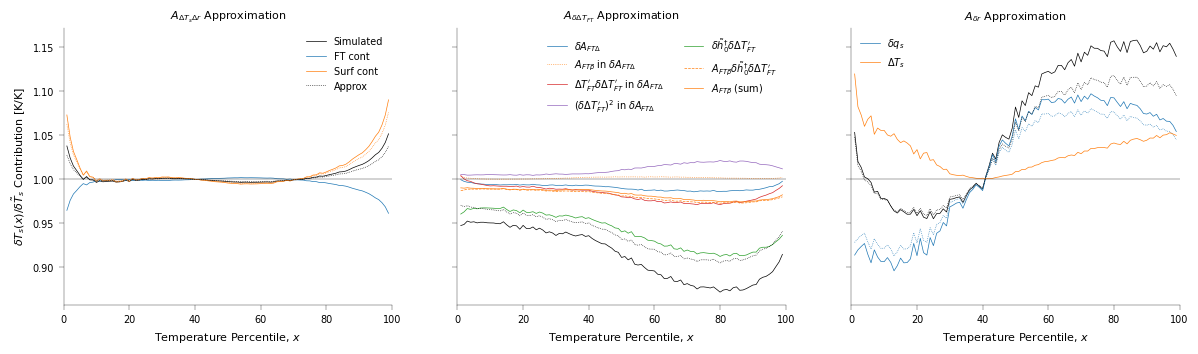

In [776]:
def mse_to_sf_cont(var):
    return var/(beta_s1[0]*np.diff(temp_ref[:, ind_surf], axis=0).squeeze())[:, np.newaxis]
sf_approx_simple = {}
fig, ax = plt.subplots(1,3, figsize=(3*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)

# temp_r_anom
ax[0].plot(quant_plot, 1+np.average(sf_approx_breakdown_func['anom_temp_s_r'], axis=0, weights=lat_weights), color='k', label='Simulated')
ax[0].plot(quant_plot, 1+np.average(mse_to_sf_cont(mse_mod_anom_ft_change_cont2['approx_anom_temp_r1']), axis=0, weights=lat_weights),
           color=default_colors[0], label='FT cont')  # + as comes from ft mse
ax[0].plot(quant_plot, 1-np.average(mse_to_sf_cont(mse_mod_anom_s_change_cont2['approx_anom_temp_r2']), axis=0, weights=lat_weights),
           color=default_colors[1], label='Surf cont') # - as comes from surf mse
var = (beta_s2[0]/temp_ref[0, ind_surf] * np.diff(temp_ref[:, ind_surf], axis=0).squeeze())[:, np.newaxis] * r_anom[0]/r_ref[0, :, np.newaxis] * temp_anom[0, ind_surf]
ax[0].plot(quant_plot, 1-np.average(mse_to_sf_cont(var), axis=0, weights=lat_weights),
           color=default_colors[1], linestyle=':')
sf_approx_simple['anom_temp_s_r'] = mse_to_sf_cont(mse_mod_anom_ft_change_cont2['approx_anom_temp_r1'] - var)
ax[0].plot(quant_plot, 1+np.average(sf_approx_simple['anom_temp_s_r'], axis=0, weights=lat_weights),
           color='k', label='Approx', linestyle=':')
ax[0].legend()
ax[0].set_title('$A_{\Delta T_s \Delta r}$ Approximation')

# temp_ft_change - delta A_FT\Delta cont (+ as comes from ft mse)
ax[1].plot(quant_plot, 1+np.average(sf_approx_breakdown_func['temp_ft_anom_change'], axis=0, weights=lat_weights), color='k')
ax[1].plot(quant_plot, 1+np.average(mse_to_sf_cont(np.diff(approx['ft_anom'], axis=0).squeeze()), axis=0, weights=lat_weights), color=default_colors[0],
           label='$\delta A_{FT\Delta}$')
var_beta_cont = [np.diff(0.5 * (beta_ft2/temp_ref[:, ind_ft]), axis=0).squeeze()[:, np.newaxis]  * temp_anom[1, ind_ft]**2]
ax[1].plot(quant_plot, 1+np.average(mse_to_sf_cont(var_beta_cont[0]), axis=0, weights=lat_weights), color=default_colors[1], linestyle=':',
           label='$A_{FT\\beta}$ in $\delta A_{FT\Delta}$')
# ax[1].plot(quant_plot, 1+np.average(mse_to_sf_cont(var-var_beta_cont[0]), axis=0, weights=lat_weights), color=default_colors[3])
var = (beta_ft2[0]/beta_ft1[0] / temp_ref[0, ind_ft])[:, np.newaxis] * mse_mod_anom0 * temp_ft_anom_change_mod
# var = 0.5*(beta_ft2/temp_ref[:, ind_ft])[0, :, np.newaxis] * np.diff(temp_anom[:, ind_ft]**2, axis=0).squeeze()
ax[1].plot(quant_plot, 1+np.average(mse_to_sf_cont(var), axis=0, weights=lat_weights), color=default_colors[3],
           label="$\Delta T_{FT}'\delta \Delta T_{FT}'$ in $\delta A_{FT\Delta}$")
var = 0.5*(beta_ft2[0]/temp_ref[0, ind_ft])[:, np.newaxis] * temp_ft_anom_change_mod**2
ax[1].plot(quant_plot, 1+np.average(mse_to_sf_cont(var), axis=0, weights=lat_weights), color=default_colors[4],
           label="$(\delta \Delta T_{FT}')^2$ in $\delta A_{FT\Delta}$")

# temp_ft_change - \delta h_0 \delta \Delta T_{FT} cont
var = (prefactor_mse_ft * beta_ft1[0] * mse_mod_ref_change0)[:, np.newaxis] * temp_ft_anom_change_mod
ax[1].plot(quant_plot, 1+np.average(mse_to_sf_cont(var), axis=0, weights=lat_weights), color=default_colors[2],
           label="$\delta \\tilde{h}^{\dagger}_0\delta \Delta T_{FT}'$")
var_beta_cont += [var*approx['ft_beta'][:, np.newaxis]]
ax[1].plot(quant_plot, 1+np.average(mse_to_sf_cont(var_beta_cont[1]), axis=0, weights=lat_weights), color=default_colors[1], linestyle='--',
           label="$A_{FT\\beta}\delta \\tilde{h}^{\dagger}_0\delta \Delta T_{FT}'$")
ax[1].plot(quant_plot, 1+np.average(mse_to_sf_cont(var_beta_cont[0]+var_beta_cont[1]), axis=0, weights=lat_weights), color=default_colors[1],
           label='$A_{FT\\beta}$ (sum)')
sf_approx_simple['temp_ft_anom_change'] = mse_to_sf_cont(var + (beta_ft2[0]/beta_ft1[0] / temp_ref[0, ind_ft])[:, np.newaxis]
                                                                        * mse_mod_anom0 * temp_ft_anom_change_mod +
                                                                        0.5*(beta_ft2[0]/temp_ref[0, ind_ft])[:, np.newaxis] * temp_ft_anom_change_mod**2)
ax[1].plot(quant_plot, 1+np.average(sf_approx_simple['temp_ft_anom_change'], axis=0, weights=lat_weights),
           color='k', linestyle=':')
ax[1].legend(ncol=2)
ax[1].set_title('$A_{\delta \Delta T_{FT}}$ Approximation')
# var = var*approx['ft_beta'][:, np.newaxis] + np.diff(0.5 * (beta_ft2/temp_ref[:, ind_ft]), axis=0).squeeze()[:, np.newaxis]  * temp_anom[0, ind_ft]**2
# ax[1].plot(quant_plot, 1+np.average(mse_to_sf_cont(var), axis=0, weights=lat_weights), color='k')
#ax[1].plot(quant_plot, 1+np.average(mse_to_sf_cont(var+np.diff(approx['ft_anom'], axis=0).squeeze()), axis=0, weights=lat_weights))



# r_change (minus as comes from surface mse)
ax[2].plot(quant_plot, 1+np.average(sf_approx_breakdown_func['r_change'], axis=0, weights=lat_weights), color='k')
var = [L_v * np.diff(sphum_ref, axis=0).squeeze()[:, np.newaxis] * np.diff(r_anom/r_ref[:, :, np.newaxis], axis=0).squeeze()]
ax[2].plot(quant_plot, 1-np.average(mse_to_sf_cont(var[0]), axis=0, weights=lat_weights), color=default_colors[0], label='$\delta q_s$')
# Approx sphum_ref_change term
var += [(mu[0]*beta_s1[0]*np.diff(temp_ref[:, ind_surf], axis=0).squeeze())[:, np.newaxis] * np.diff(r_anom/r_ref[:, :, np.newaxis], axis=0).squeeze()]
ax[2].plot(quant_plot, 1-np.average(mse_to_sf_cont(var[1]), axis=0, weights=lat_weights), color=default_colors[0], linestyle=':')
# Get temp_anom contribution
var += [(mu[0]*beta_s1[0])[:, np.newaxis] * temp_anom[0, ind_surf] * np.diff(r_anom/r_ref[:, :, np.newaxis], axis=0).squeeze()]
ax[2].plot(quant_plot, 1-np.average(mse_to_sf_cont(var[2]), axis=0, weights=lat_weights), color=default_colors[1], label='$\Delta T_s$')
sf_approx_simple['r_change'] = -mse_to_sf_cont(var[1]+var[2])
ax[2].plot(quant_plot, 1+np.average(sf_approx_simple['r_change'], axis=0, weights=lat_weights),
           color='k', linestyle=':')
ax[2].legend()
ax[2].set_title('$A_{\delta r}$ Approximation')
ax[0].set_ylabel('$\delta T_s(x)/\delta \\tilde{T}_s$ Contribution [K/K]')
# ax[0].plot(quant_plot, 1+np.average(sf_approx_breakdown_func['r_change_approx']+sf_approx_breakdown_func['temp_ft_anom_change_approx']
#                                     +sf_approx_breakdown_func['anom_temp_s_r_approx'], axis=0, weights=lat_weights),
#            color='k', label='Approx', linestyle=':')

ax[0].set_xlim(0, 100)
for ax_use in ax:
    ax_use.axhline(1, color='k', lw=ax_linewidth)
    ax_use.set_xlabel('Temperature Percentile, $x$')
plt.show()

In [777]:
# Sanity check gives same as function
sf_approx_simple_from_func = {key: np.zeros_like(sf_approx_simple[key]) for key in sf_approx_simple}
for i in range(n_lat):
    var_use = get_approx_terms(temp_ref[:, ind_surf, i], temp_quant3[:, ind_surf, i], r_ref[:, i], r_quant3[:, i],
                               temp_quant3[:, ind_ft, i], epsilon_quant3[:, i], p_surface, pressure_ft_actual,
                               epsilon_ref[:, i], z_approx_error_ref[:, i], simple=True)[0]
    for key in sf_approx_simple_from_func:
        sf_approx_simple_from_func[key][i] = var_use[key]

for key in sf_approx_simple:
    print(key + ': {:.5g}'.format(np.max(np.abs(sf_approx_simple_from_func[key] - sf_approx_simple[key]))))

anom_temp_s_r: 2.7756e-17
temp_ft_anom_change: 5.5511e-17
r_change: 5.5511e-17


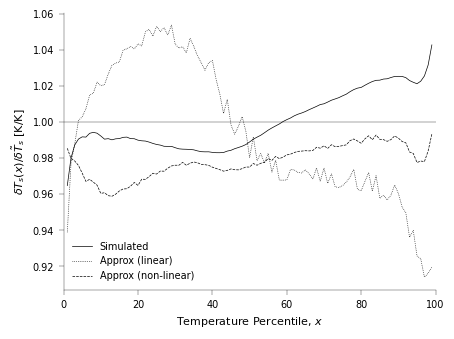

In [778]:
fig, ax = plt.subplots(1,1, figsize=(im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
ax.plot(quant_plot, np.average(sf_simulated, axis=0, weights=lat_weights), color='k', label='Simulated')
ax.plot(quant_plot, np.average(sf_theory, axis=0, weights=lat_weights), color='k', linestyle=':', label='Approx (linear)')
ax.plot(quant_plot, np.average(sf_theory+sf_approx_simple['r_change']+sf_approx_simple['temp_ft_anom_change']
                                    +sf_approx_simple['anom_temp_s_r'], axis=0, weights=lat_weights), color='k',
        linestyle='--', label='Approx (non-linear)')
# ax.plot(quant_plot, np.average(sf_theory+sf_approx_simple['r_change']+sf_approx_simple['temp_ft_anom_change']
#                                     +sf_approx_simple['anom_temp_s_r']+0.01, axis=0, weights=lat_weights), color='b',
#         linestyle='--', label='Approx (non-linear) $+0.01$')
ax.axhline(1, color='k', lw=ax_linewidth)
ax.set_xlabel('Temperature Percentile, $x$')
ax.set_xlim(0, 100)
ax.set_ylabel('$\delta T_s(x)/\delta \\tilde{T}_s$ [K/K]')
ax.legend()
plt.show()

## Lapse Rate Change
Sometimes, it is easier to think of the effect of different mechanisms through how they affect the lapse rate or $T_s - T_{FT}$. Below I show this. All lines quantify how the moist adiabat lapse rate change, except for the orange solid line in the middle column, which quantifies the extent to which the lapse rate change deviates from that expected from the moist adiabat.

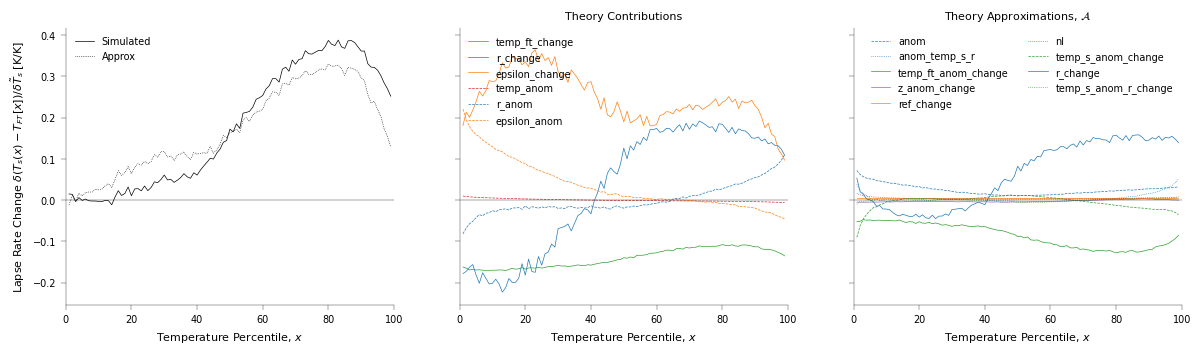

In [779]:
fig, ax = plt.subplots(1,3, figsize=(3*im_sz*width['one_col'], im_sz*width['one_col']/ar), sharex=True, sharey=True)
ax[0].plot(quant_plot, np.average(sf_simulated -
                                  np.diff(temp_quant3[:, ind_ft], axis=0).squeeze()/np.diff(temp_ref[:, ind_surf], axis=0).squeeze()[:, np.newaxis],
                                  axis=0, weights=lat_weights), color='k', label='Simulated')
ax[0].plot(quant_plot, np.average(sf_theory -
                                  np.diff(temp_quant3[:, ind_ft], axis=0).squeeze()/np.diff(temp_ref[:, ind_surf], axis=0).squeeze()[:, np.newaxis],
                                  axis=0, weights=lat_weights), color='k', linestyle=':', label='Approx')

for key in sf_theory_cont:
    if (not use_av_as_ref) and (key == 'r_ref_change'):
        continue
    ax[1].plot(quant_plot, np.average((-np.diff(temp_quant3[:, ind_ft], axis=0).squeeze()/np.diff(temp_ref[:, ind_surf], axis=0).squeeze()[:, np.newaxis]
                            if key=='temp_ft_change' else 0) + sf_theory_cont[key], axis=0, weights=lat_weights),
               label=key, linestyle=linestyle_cont[key], color=colors_cont[key])

for key in temp_anom_change_cont2:
    if 'approx' in key:
        ax[2].plot(quant_plot, np.average(temp_anom_change_cont2[key]/(beta_s1[0]*np.diff(temp_ref[:, ind_surf], axis=0).squeeze())[:, np.newaxis],
                                            axis=0, weights=lat_weights),
                   label=key.replace('approx_', ''), color=colors_approx[key.replace('approx_', '')],
                   linestyle=linestyle_approx[key.replace('approx_', '')])

for i, ax_use in enumerate(ax):
    ax_use.legend(ncol=2 if i==2 else 1)
    ax_use.axhline(0, color='k', lw=ax_linewidth)
    ax_use.set_xlabel('Temperature Percentile, $x$')
ax[0].set_xlim(0, 100)
ax[1].set_title('Theory Contributions')
ax[2].set_title('Theory Approximations, $\mathcal{A}$')
ax[0].set_ylabel('Lapse Rate Change $\delta \\left(T_s(x) - T_{FT}[x]\\right)/\delta \\tilde{T}_s$ [K/K]')
# if use_av_as_ref:
#     ax[0].set_ylim(0.8, 1.2)
# else:
#     ax[0].set_ylim(0.55, 1.3)
plt.show()
# isca_tools.savefig(fig)